# Project 2 - Ames Housing Data and Kaggle Challenge
![](./assets/images/Suburb_header_image.png)
[Image Source](https://homeownershipmatters.realtor/issues/these-3-suburbs-are-leading-the-way-in-the-u-s-markets-suburban-boom/)

## Table of Content

1. [Background](#Background)
2. [Functions](#Functions)
3. [Python Libraries Used](#Libraries)
4. [Dataset](#Dataset)
5. [Data Wrangling](#Data_Wrangling)
6. [Null Values](#Null_Values)
7. [EDA](#EDA)
8. [Model Preprocessing](#Model_Preprocessing)
9. [Machine Learning](#Machine_Learning)
10. [Kaggle Submission](#Kaggle_Submission)
11. [Conclusion](#Conclusion)
12. [Recommendations](#Recommendations)

## Background

Purpose of this project is to create regression models based on the Ames Housing Dataset. This model will be used to predict the price of a house on sales.

The Ames Housing Dataset is an exceptionally detailed and robust dataset with over 70 columns of different features relating to houses.

The results of testing the model will be submitted to [Kaggle](https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge)

The rough focus would be to create a program for a real estate agents to better estimate the selling price of a house they would like to market

First I'll be prepping the dataset by doing feature engineering, dropping some variables and doing general cleaning.
I'll then do some simple exploratory data analysis on the cleaned data and finally fit the data into different regression models to try and predict as close as possible the actual sale price of past tranacted properties.

## Functions

In [1]:
#Function to fill in null values base on whether its an object
def clean_null_obj(df):
    obj_cols = df.select_dtypes([object]).columns
    df[obj_cols] = df[obj_cols].fillna("NA")
    return df

In [2]:
#Function to fill in null values base on whether its an int/float
def clean_null_num(df):
    n_cols = df.select_dtypes([np.int64,np.float64]).columns
    df[n_cols] = df[n_cols].fillna(0)
    return df

In [3]:
# Function to clean the categorical variables in the dataset

def clean_df_cat(df):
    
    #Drop Category columns
    df = df.drop(['Exterior 2nd','Exterior 1st','Fence','Misc Feature','Garage Qual','Heating',
                  'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Roof Style','Land Slope',
                  'Lot Config','Utilities','Street'],axis =1)
    
    #Feature Engineering
    df['Garage Cond']= df['Garage Cond'].apply(lambda x: 'a' if (x == 'Gd')|(x=='Ex')else 'b')
    df['Garage Type'] = df['Garage Type'].apply(lambda x: 'a' if (x=='Attchd')|(x=='BuiltIn')|(x=='2Types') else 'b')
    df['Fireplace Qu'] = df['Fireplace Qu'].apply(lambda x: 'a' if (x=='Ex') else('c' if (x=='Po')|(x=='TA')else 'b'))
    df['Functional'] = df['Functional'].apply(lambda x: 'b' if (x=='Sal')|(x=='Sev')|(x=='Maj2') else 'a')
    df['Electrical'] = df['Electrical'].apply(lambda x: 'a' if (x=='SBrkr') else 'b')
    df['Heating QC'] = df['Heating QC'].apply(lambda x: 'a' if (x=='Ex') else('c' if (x=='Po') else 'b'))
    df['Bsmt Cond'] = df['Bsmt Cond'].apply(lambda x: 'a' if (x=='Ex')|(x=='Gd')|(x=='TA') else 'b')
    df['Bsmt Qual'] = df['Bsmt Qual'].apply(lambda x: 'a' if (x=='Ex') else('b' if (x=='Gd')else 'c'))
    df['Exter Cond'] = df['Exter Cond'].apply(lambda x: 'a' if (x=='Ex') else('c' if (x=='Po') else 'b'))
    df['Exter Qual'] = df['Exter Qual'].apply(lambda x: 'a' if (x=='Ex') else('b' if (x=='Gd') else 'c'))
    df['Condition 2'] = df['Condition 2'].apply(lambda x: 'a' if (x == 'PosA')|(x=='PosN') else 'b')
    df['Foundation'] = df['Foundation'].apply(lambda x: 'others' if (x!='Wood')&(x!='PConc') else x)
    df['Roof Matl'] = df['Roof Matl'].apply(lambda x: 'wood' if (x=='WdShake')|(x=='WdShngl') else 'others')
    
    return df

In [4]:
# Function to prep numbrical variables
def clean_data_numerical(df):
    
    #Drop Columns
    df = df.drop(['Mo Sold','Misc Val','Pool Area','Wood Deck SF','Garage Yr Blt','Kitchen AbvGr',
                  'Bedroom AbvGr','Half Bath','Bsmt Half Bath','Low Qual Fin SF','Bsmt Unf SF',
                  'Lot Area','Lot Frontage','PID'],axis=1)
    
    #Feature Engineering
    #Map MS SubClass to 3 broad categories
    df['MS SubClass'] = df['MS SubClass'].apply(lambda x: 'a' if (x==120)|(x==60) else('b' if (x==75) else 'c'))
    
    #Map Bsmt Full Bath to 3 categories
    df['Bsmt Full Bath'] = df['Bsmt Full Bath'].apply(lambda x: 'NA' if (x==0) else('One' if (x==1) else 'Multi'))
    
    #Map Fireplaces to 3 catergories
    df['Fireplaces'] = df['Fireplaces'].apply(lambda x: 'NA' if (x==0) else('1-2' if (x<=2) else '>2'))
    
    #Map Full Bath to 3 categories
    df['Full Bath'] = df['Full Bath'].apply(lambda x: '0-1' if (x<=1) else('2' if (x==2) else '>2'))
    
    #Combine Porch variables
    df['Porch']= df.apply(lambda x: 'open' if x['Open Porch SF'] >0 else('enclosed' if x['Enclosed Porch']>0 
                                                                         else('3Ssn' if x['3Ssn Porch'] > 0 
                                                                              else('screen' if x['Screen Porch']>0 
                                                                                  else 'NA'))),axis =1)
    #Create variable for age from built to sold
    df['Age Sold'] = df.apply(lambda x: 0 if x['Yr Sold']-x['Year Built']<1 #filter out negative numbers
                              else x['Yr Sold']-x['Year Built'],axis=1)
    
    #Create variable for remodeled to sold
    df['Age Remodeled'] = df.apply(lambda x: 0 if (x['Year Remod/Add']-x['Year Built']<1) #This would filter out -1 value
                                   else (x['Yr Sold']-x['Year Remod/Add']),axis=1)
    
    #Create a variable BsmtFin Total SF
    df['BsmtFin Total SF'] = df.apply(lambda x: x['BsmtFin SF 1']+x['BsmtFin SF 2'],axis=1)
    
    #Drop combined/merge columns
    df = df.drop(['Garage Cars','Year Remod/Add','Year Built','Yr Sold','Screen Porch','3Ssn Porch',
                  'Enclosed Porch','Open Porch SF','BsmtFin SF 2','BsmtFin SF 1'],axis=1)
    
    #set ID to index
    df.set_index('Id',inplace = True)
    
    return df

In [5]:
# Function to run boxplots
def create_boxplot(df,col):
    x = df[[col,'SalePrice']]
    sns.boxplot(x=col,y='SalePrice',data=x)
    plt.title(col+' vs Sale Price')

In [6]:
# Function to run scatterplot
def create_scatterplot(df,col):
    sns.scatterplot(data=df,x=col,y='SalePrice')
    plt.title(col+' vs Sale Price')

In [7]:
# Function to plot quantile-quantile plot
def qq_plot(pred):
    p = np.linspace(0,100,100)
    pred_percentile = np.percentile(pred,p)
    test_percentile = np.percentile(y_test,p)
    plt.plot(pred_percentile,test_percentile, ls="", marker="o")
    x = np.linspace(np.min((pred_percentile.min(),test_percentile.min())), np.max((pred_percentile.max(),test_percentile.max())))
    plt.plot(x,x, color="r", ls="--")
    plt.xlabel('Actual Sale Price')
    plt.ylabel('Predicted Sale Price')
    

In [8]:
# Function to clean test dataset for kaggle submission
def kaggle_submission(df):
    # Fill in null value in catergorical data as "NA"
    df = clean_null_obj(df)
    # Run Function to wrangle the caterogrical variables
    df = clean_df_cat(df)
    # Run Function to wrangle the numerical variables
    df = clean_data_numerical(df)
    #Fill numerical null values
    df = clean_null_num(df) 
    return df

In [9]:
# Function to get the top 10 and bottom 10 coefficients
def top_bottom_coef(model,name):
    df = pd.concat([pd.DataFrame(model.coef_,index=list(Z.columns)).sort_values(by=0,ascending=False).head(10),
                pd.DataFrame(model.coef_,index=list(Z.columns)).sort_values(by=0,ascending=False).tail(10)])
    df.rename({0:name},axis = 1,inplace = True)
    return df

## Libraries

In [10]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, LinearRegression
from sklearn import metrics
from scipy import stats

#ignore SettingWithCopyWarning
pd.options.mode.chained_assignment = None 

## Dataset

The Ames Housing Dataset for this project is split into two. One would be used to train the model and the other to test how well the model does.

They can be found [here](https://www.kaggle.com/c/dsi-us-11-project-2-regression-challenge/data).

The description of the dataset can be found [here](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

## Train_Dataset

In [11]:
#import the train dataset
train_dataset = './assets/datasets/train.csv'
df_train = pd.read_csv(train_dataset)

In [12]:
#Look at the number of rows and columns
df_train.shape

(2051, 81)

In [13]:
#Check the data types
df_train.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

## Test_Dataset

In [14]:
#import the test dataset
test_dataset = './assets/datasets/test.csv'
df_test = pd.read_csv(test_dataset)

In [15]:
#Look at the number of rows and columns
df_test.shape

(878, 80)

In [16]:
#Check the data types in the dataset
df_test.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

## Data_Wrangling

The variables can be split between two types: Categorical (objects) and Numerical (int or float).
I'll be using boxplots for catergorical data and scatter plots for numerical data to filter out variables that do not clearly define the salesprice of a home.

The data description document given together with the dataset is of invaluable assistance in this section.

#### Special Note
From the given description of the DataSet:
"There are 5 observations that an instructor may wish to remove... Three of them are true outliers... and two of them are simply unusual sales... I would recommend removing any houses with more than 4000 square feet from the data set (which eliminates these 5 unusual observations)..."

I'll explore this first

In [17]:
# Remove houses with more than 4k sq feet as recommended
df_filtered = df_train[df_train['Gr Liv Area'] <4000]

# Note later on I did test if not removing the outliers would affect the end result and it did...

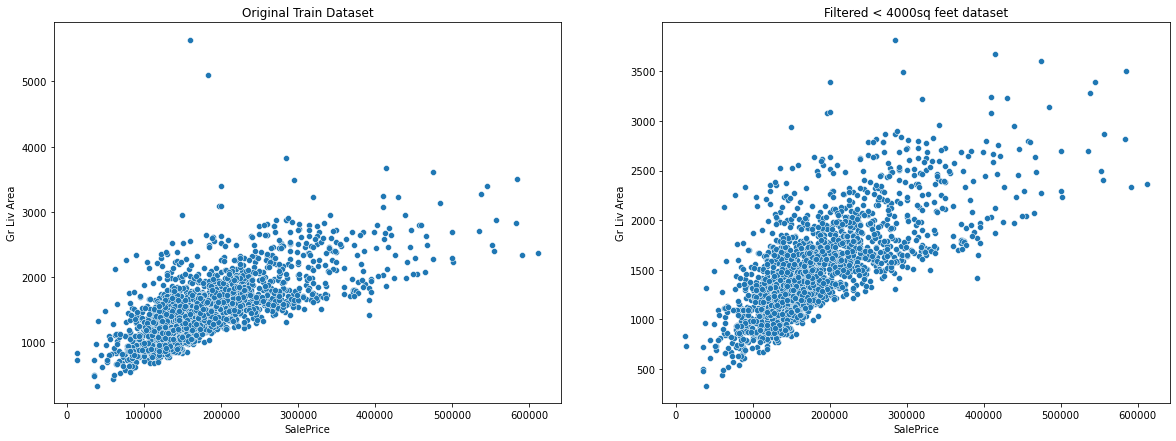

Original Train Dataset variables,observations: (2051, 81)
After Filtering for < 4,000 sq feet: (2049, 81)


In [18]:
# Plot before and after

plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_train,x='SalePrice',y='Gr Liv Area')
plt.title('Original Train Dataset')
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_filtered,x='SalePrice',y='Gr Liv Area')
plt.title('Filtered < 4000sq feet dataset')
plt.show()

print('Original Train Dataset variables,observations:',df_train.shape)
print('After Filtering for < 4,000 sq feet:',df_filtered.shape)

##### Observations
There were only 2 outliers that were filtered out.

Upon further visual inspection of the data, I've come to realise the train dataset given was a filtered version of the original.

The original had 2930 observations, 82 variables.

The given train dataset has 2051 observations and 81 variables.

Perhaps the other outliers were filtered out via the test set which has 878 observations.

The variable: "Sale Condition" which described the sales transactions as normal,abnormal,partial, etc, was also removed from the original dataset.

In [19]:
# Check for duplicates
df_filtered[df_filtered.duplicated()]

Empty DataFrame
Columns: [Id, PID, MS SubClass, MS Zoning, Lot Frontage, Lot Area, Street, Alley, Lot Shape, Land Contour, Utilities, Lot Config, Land Slope, Neighborhood, Condition 1, Condition 2, Bldg Type, House Style, Overall Qual, Overall Cond, Year Built, Year Remod/Add, Roof Style, Roof Matl, Exterior 1st, Exterior 2nd, Mas Vnr Type, Mas Vnr Area, Exter Qual, Exter Cond, Foundation, Bsmt Qual, Bsmt Cond, Bsmt Exposure, BsmtFin Type 1, BsmtFin SF 1, BsmtFin Type 2, BsmtFin SF 2, Bsmt Unf SF, Total Bsmt SF, Heating, Heating QC, Central Air, Electrical, 1st Flr SF, 2nd Flr SF, Low Qual Fin SF, Gr Liv Area, Bsmt Full Bath, Bsmt Half Bath, Full Bath, Half Bath, Bedroom AbvGr, Kitchen AbvGr, Kitchen Qual, TotRms AbvGrd, Functional, Fireplaces, Fireplace Qu, Garage Type, Garage Yr Blt, Garage Finish, Garage Cars, Garage Area, Garage Qual, Garage Cond, Paved Drive, Wood Deck SF, Open Porch SF, Enclosed Porch, 3Ssn Porch, Screen Porch, Pool Area, Pool QC, Fence, Misc Feature, Misc Val, Mo Sold, Yr Sold, Sale Type, SalePrice]
Index: []

[0 rows x 81 columns]

##### Observations
Looks like there are no duplicated rows to worry about.

### Catergorical Data

In [20]:
# Fill in null value in catergorical data as "NA" to reflect that there isn't that attribute in the variable for that
# particualar property

df_filtered = clean_null_obj(df_filtered)

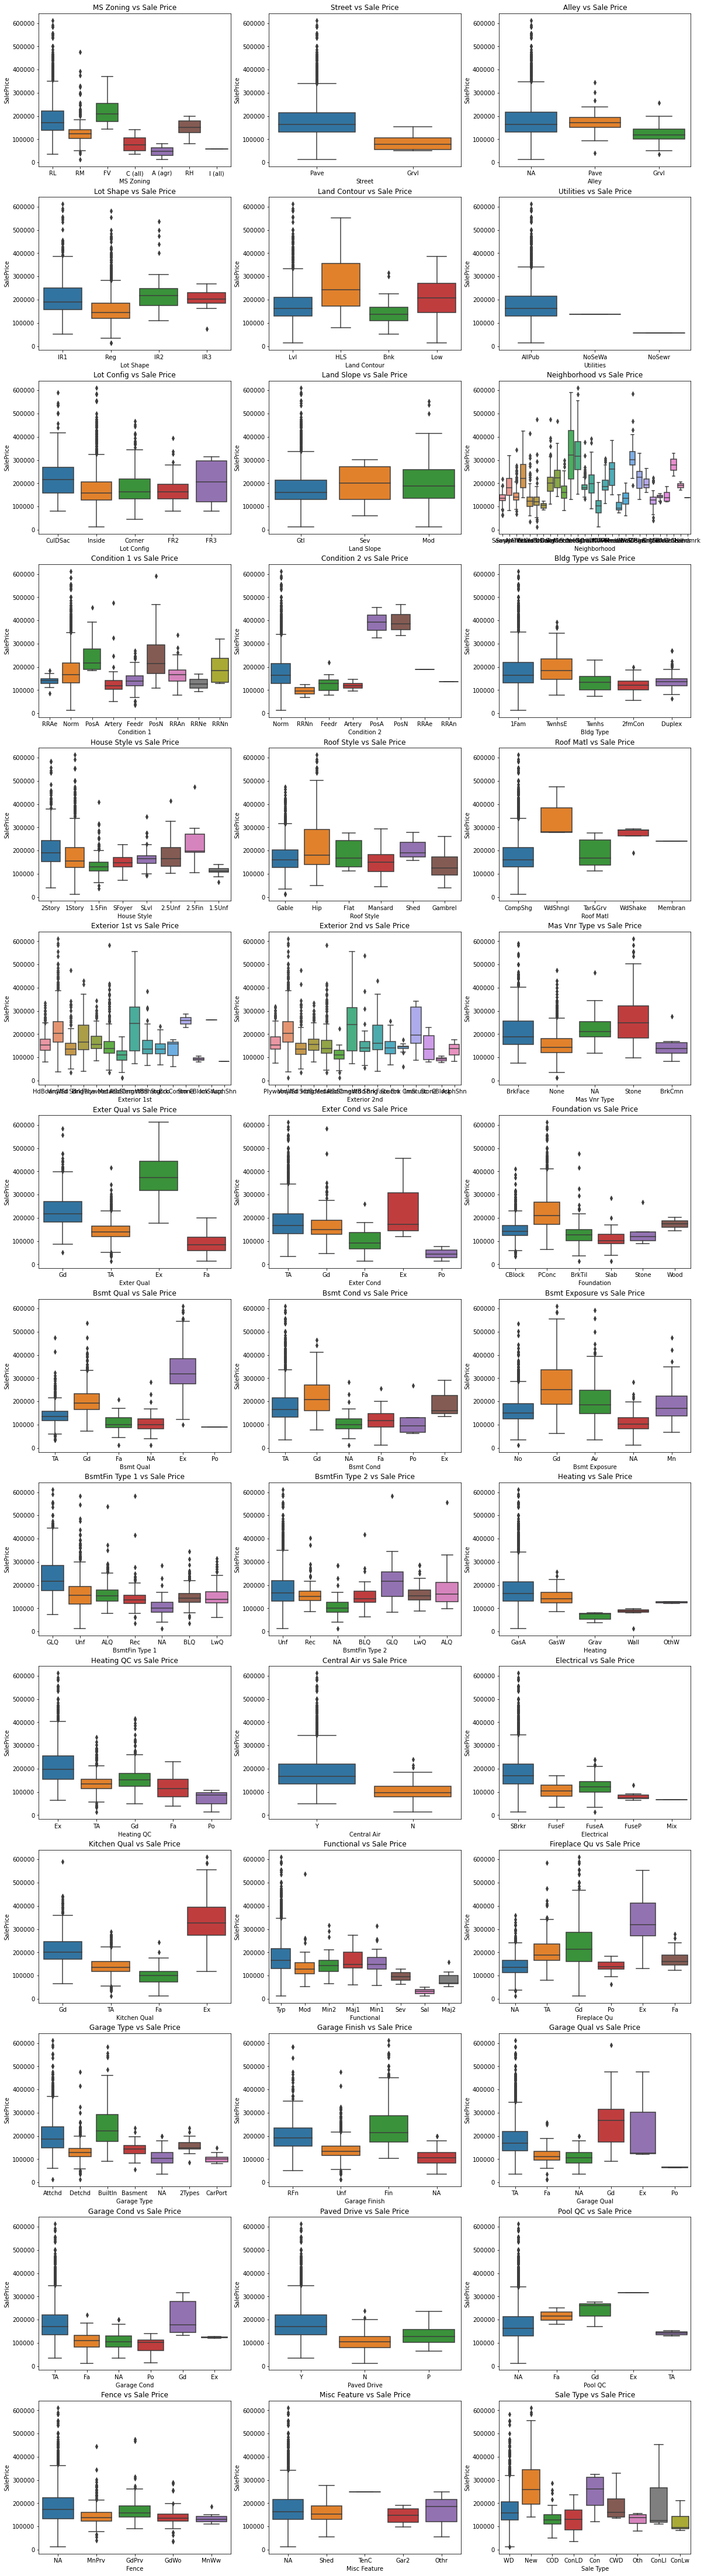

In [21]:
# List of Object type columns to run on
columns_cat = list(df_filtered.dtypes.index[df_filtered.dtypes=='object'])

# Loop through list to display plots
plt.figure(figsize=(20,80))
for i,column in enumerate(columns_cat):
        plt.subplot(14,3,i+1)
        create_boxplot(df_filtered,column) #function create_boxplot

plt.show()

#### Observations
1. Variables to drop: (Total:14)
|Variables| Reason for dropping|
|---|---|
Fence|not much difference in price range|
Misc Feature| not much difference in price range|
Garage Qual| Very similar to Garage Cond|
Heating| data captured in Heating QC|
Bsmt Exposure| info reflected in Bsmt Cond and Qual|
BsmtFin Type 1| info reflected in Bsmt Cond and Qual|
BsmtFin Type 2| info reflected in Bsmt Cond and Qual|
Roof Style| the different types are within the same interquartile price range|
Land Slope| there isn't much difference in the price range|
Lot Config| there isn't much difference in the price range|
Utilities| Mostly all in one category|
Street| Info captured under Alley|
Exterior 1st and 2nd| Info capture in exterior cond and quality|

2. Feature Engineering (Total:13)
|Variable|attributes|
|---|---|
Garage Cond| TA, Gd, Ex to a the rest to b|
Garage Type| Attchd, Bulitin, 2Types to a the rest to b|
Fireplace Qu| Ex as a, Gd, Fa and Gd as b, the rest as c|
Functional| Sev, Sal, Maj2 as b the rest as a|
Electrical| SBrkr as a the rest as b|
Heating QC| Ex as a, Ta,Gd, Fa as b, Po as c|
Bsmt Cond| Ex, Ta, Gd as a, the rest as b|
Bsmt Qual|Ex as 2, Gd a, the rest as b|
Foundation| PConc, Wood, and the rest as others|
Exter Cond| Ex as a, Po as c and the rest as b|
Exter Qual| Ex as a, Gd, as b, the rest as c|
Roof Matl| WdShngl and WdShake as wood and the rest as others|
Condition 2| PosA and PosN as a and the rest as b|

_Note the decision to keep, drop or merge the variables are based on a mix of logic, looking at the boxplot and researching online/ descriptive abstract of the different terms. Also not documented are the many smaller plots and comparison made between variables but cleaned up to make the code more concise for readability._

In [22]:
# Run Function to wrangle the caterogrical variables as observed above
df_filtered_1 = clean_df_cat(df_filtered)

In [23]:
dropped_cols = ['Exterior 2nd','Exterior 1st','Fence','Misc Feature','Garage Qual','Heating',
                'Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2',
                'Roof Style','Land Slope','Lot Config','Utilities','Street']
updated_cat_col = [x for x in columns_cat if x not in dropped_cols]

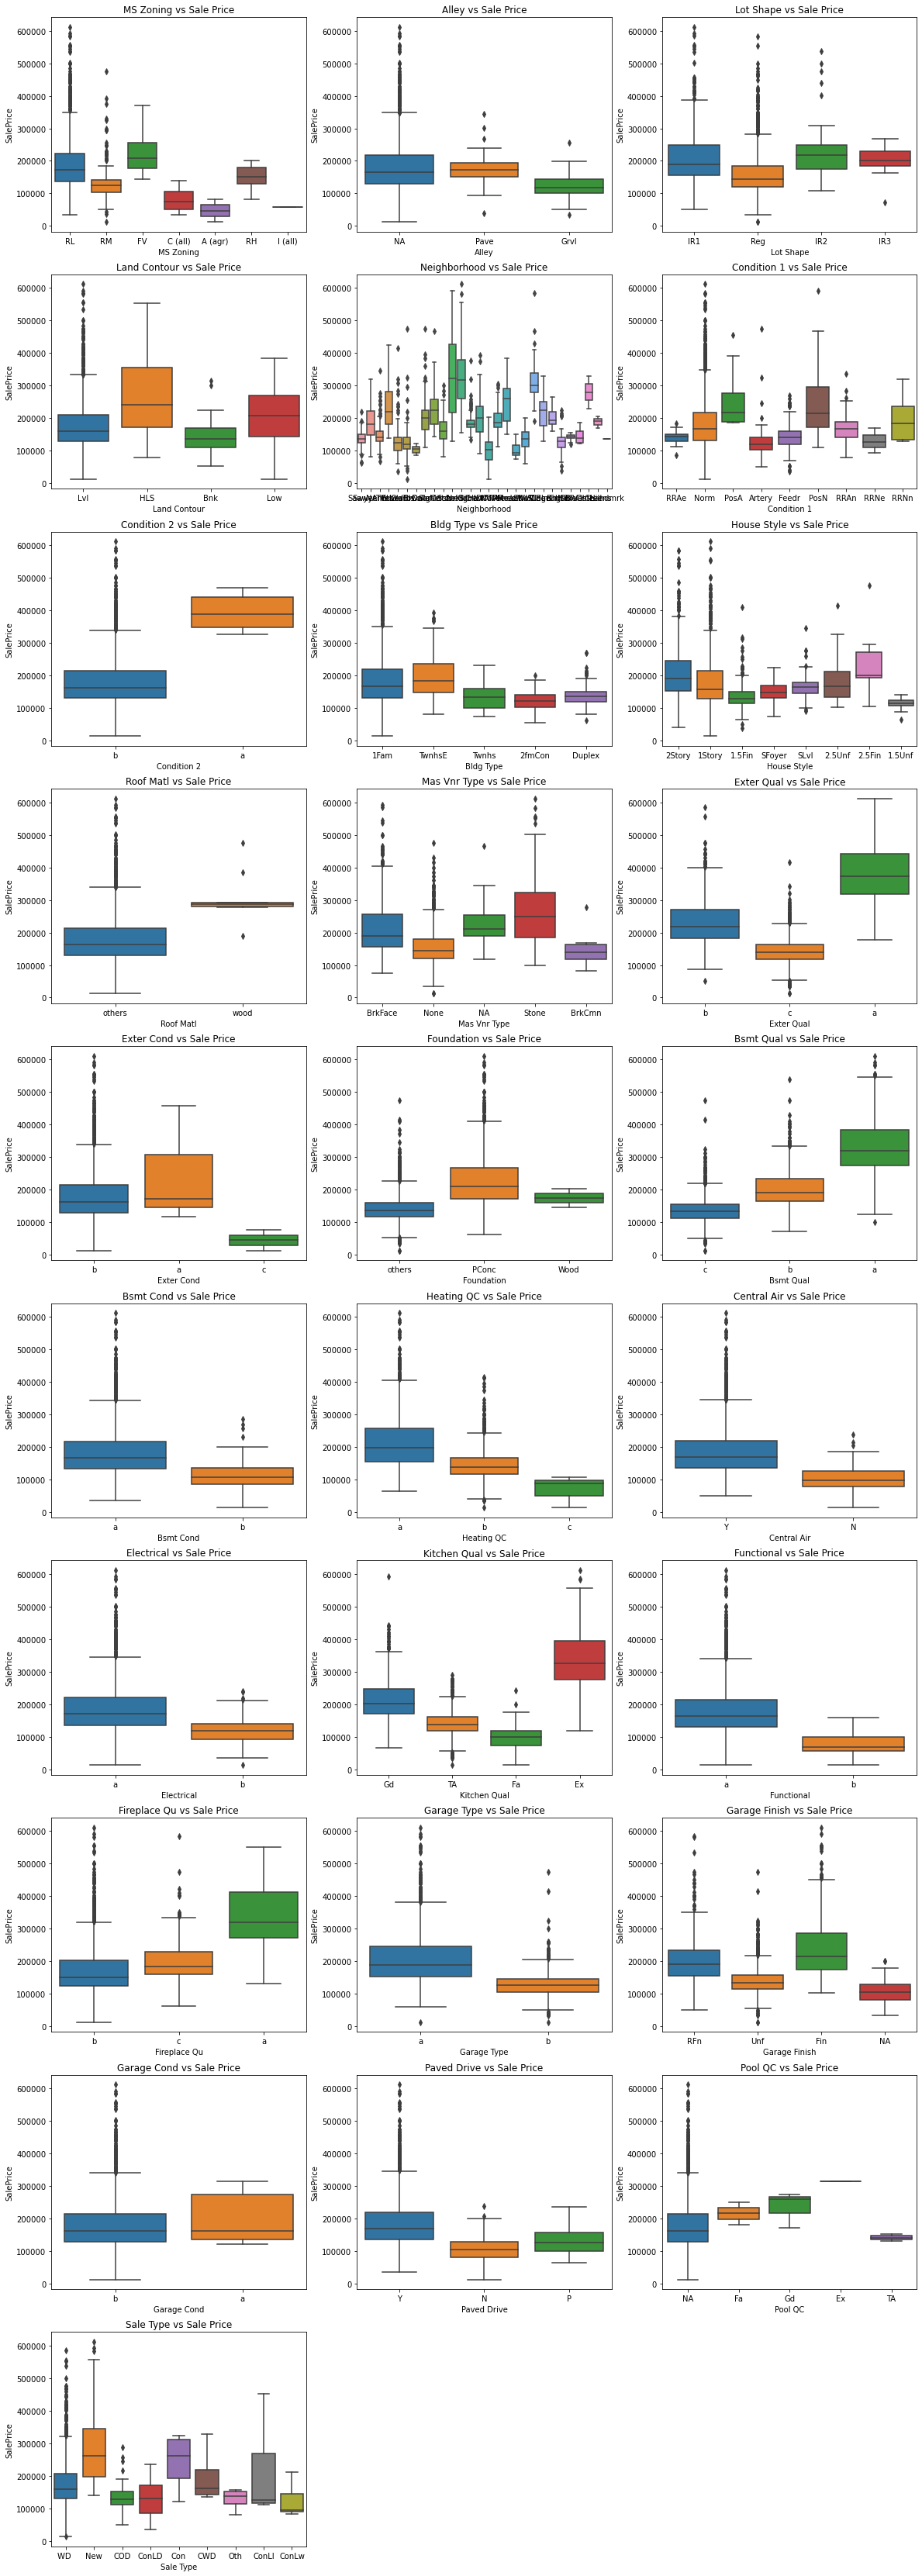

In [24]:
# Loop through remaining 'cleaned' categorical data to display plots
plt.figure(figsize=(20,60))
for i,column in enumerate(updated_cat_col):
        plt.subplot(10,3,i+1)
        create_boxplot(df_filtered_1,column) #function create_boxplot

plt.show()

#### Observations

After cleaning up the catergorical variables, I'm pretty satisfied with the outcome, perhaps more could be done for certain categories like Neighbourhood. But I cannot decide on a way to simplified these catergories without affecting the integrity of the data.

### Numerical Data

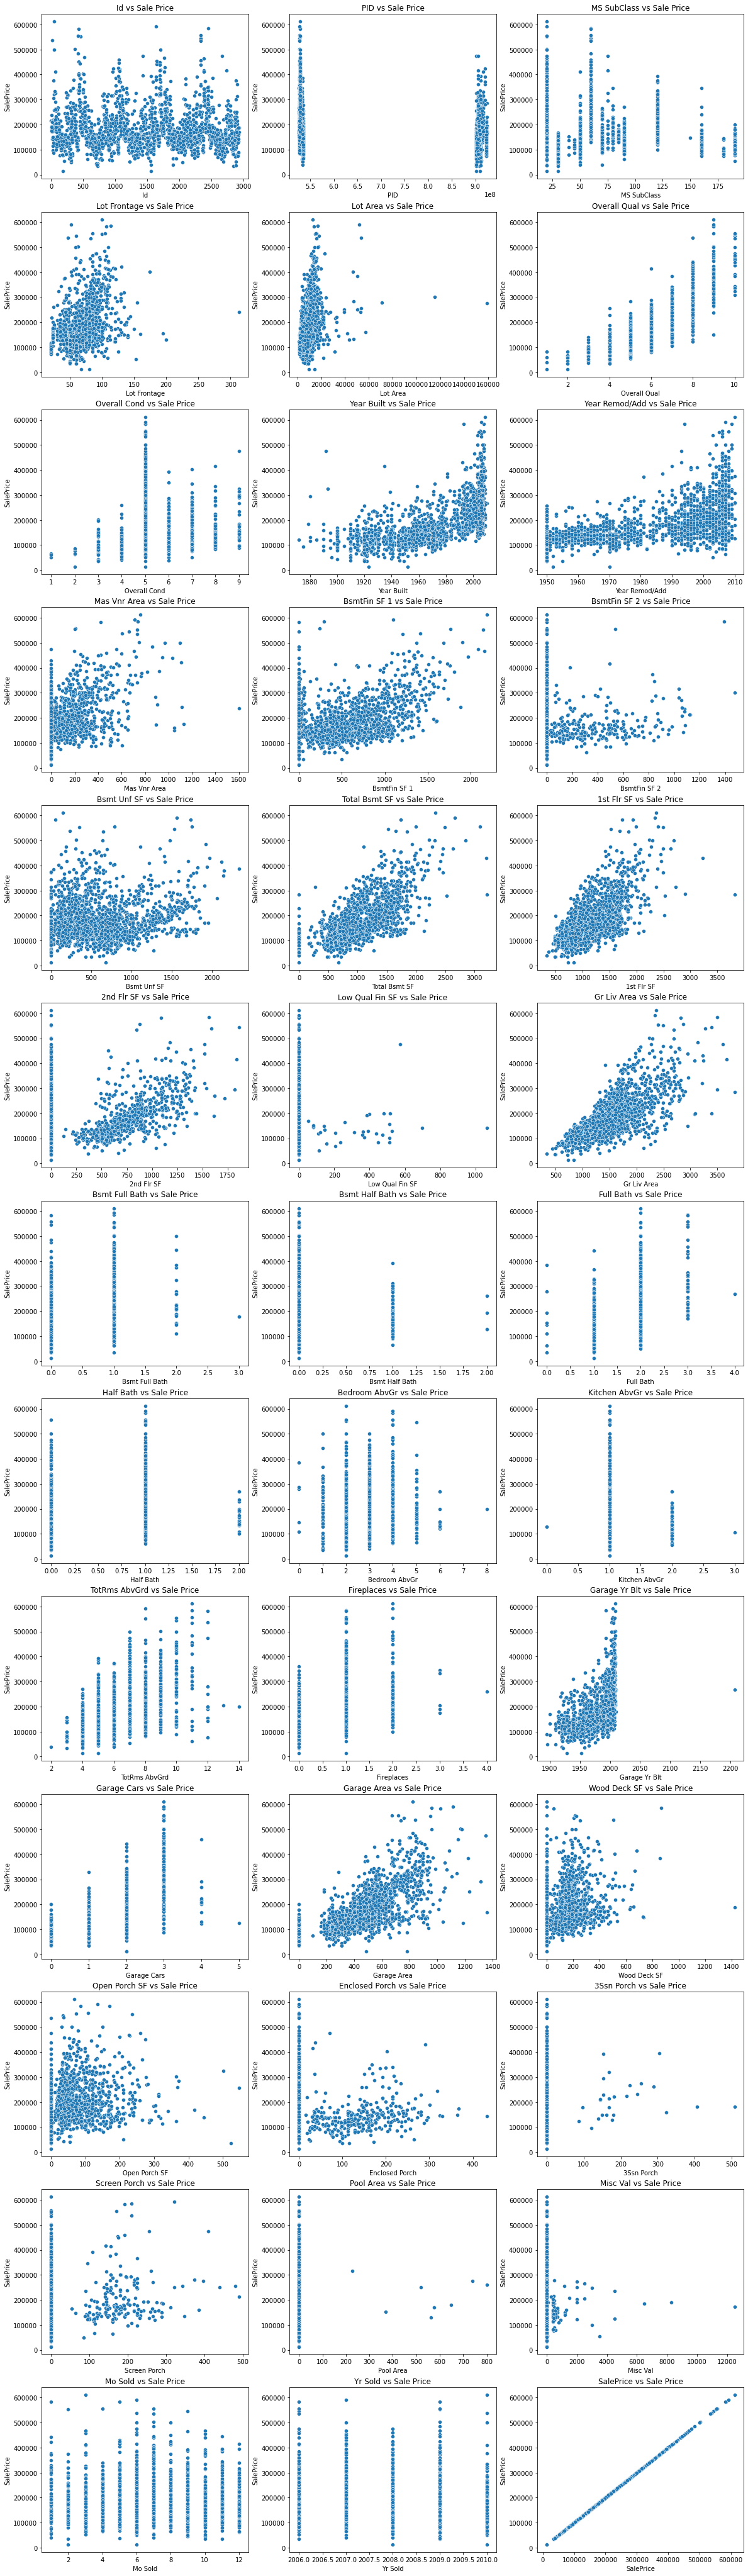

Total variables:  39


In [25]:
#Look at the relationship between the numerical data and the salesprice
#using scatterplot
columns = list(df_filtered_1.dtypes.index[(df_filtered_1.dtypes=='int64') | (df_filtered_1.dtypes=='float64')])
count = 0
plt.figure(figsize=(20,80))
for i,column in enumerate(columns):
        plt.subplot(14,3,i+1)
        create_scatterplot(df_filtered_1,column)
        count+=1
plt.show()
print('Total variables: ',count)

some of the numeric columns could be categorical:
Garage Cars,FirePlace,Kitchen AbvGr, Bedroom AbvGr, Half Bath, Full Bath, Bsmt Half Bath, Bsmt Full Bath, Overall Cond, and Overall Qual.

Lets plot their boxplots to investigate further

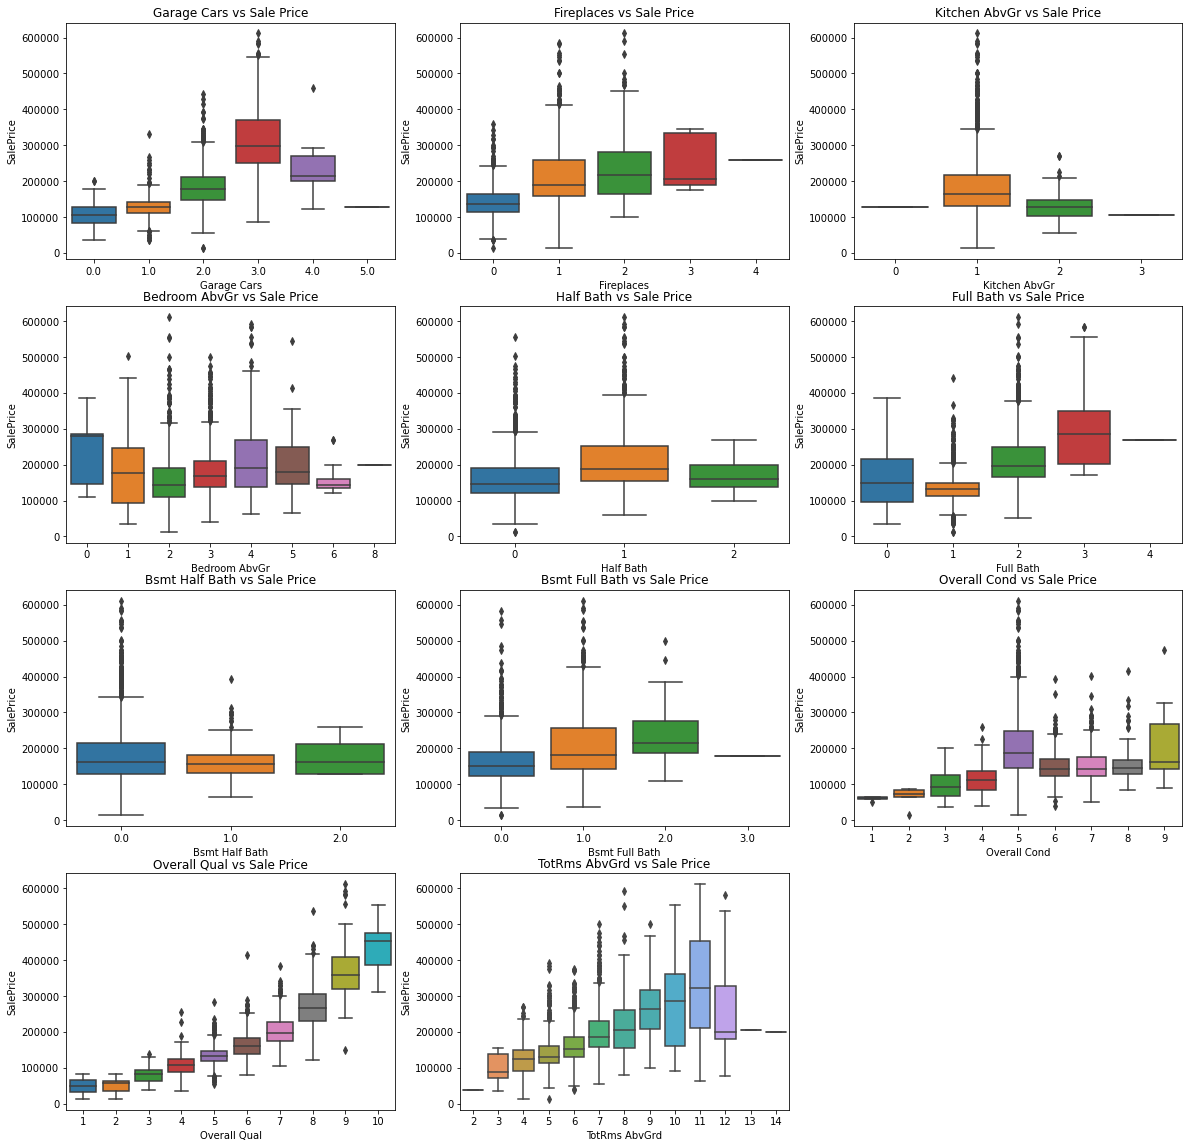

11


In [26]:
columns_cat_num = ['Garage Cars','Fireplaces','Kitchen AbvGr', 'Bedroom AbvGr', 'Half Bath', 'Full Bath', 'Bsmt Half Bath', 'Bsmt Full Bath', 'Overall Cond', 'Overall Qual','TotRms AbvGrd']
plt.figure(figsize=(20,20))
for i,column in enumerate(columns_cat_num):
        plt.subplot(4,3,i+1)
        create_boxplot(df_filtered_1,column)#function create_boxplot

plt.show()
print(len(columns_cat_num))

#### Observations

1. Variables to Drop
|Variable| Reason for dropping|
|---|---|
Id| make this as the Index
PID|This is to identify the specific property and it is not of use here
Lot Frontage|no clear pattern discernable
Lot Area| the same as Lot Frontage
Bsmt Unf SF| No clear pattern and it is not logical that the size of an unfinish basement would affect the sales price
Low Qual Fin SF| No clear pattern that can be established
Bsmt Half Bath| No clear pattern that can be established
Half Bath| No clear pattern that can be established
Bedroom AbvGr| No clear interpretation can be made. ex: 0 bedrooms does better then 6?
Kitchen AbvGr| Most are graded 1 with 2 and above not making any impact
Garage Yr Blt| There's an outlier at year 2200 and it does not make sense to price a house on the garage's age
Wood Deck SF| No clear pattern that can be established
Pool Area| this information should be captured in Pool QC
Misc Val| Established earlier with Misc Feature not contributing to the sales price range
Mo Sold| This is not going to help our consumer decide on how to price a house
Garage Cars| Captured in Garage Area

2. To Feature Engineer
* MS SubClass: 120 and 60 as 'a', 20 and 75 as 'b' the rest as 'c'
* Combine: Open Porch SF, Enclosed Porch, 3Ssn Porch and Screen Porch into one catergorical variable call Porch
* Combine: Year Sold and Year Built to get Age of the house when sold
* Combine: Year Remod/Add, Year Built, and Year Sold to see if remodeling affects
* Combine: BsmtFin SF 1 and 2 together as Total BsmtFin SF
* Bsmt Full Bath: 0 as 'NA', 1 as 'One', 2 and above as 'Multi'
* Full Bath: 0-1 as '0-1', 2 as '2', and 3 or more as '>2'
* Fireplace: 0 as 'NA', 1-2 as '1-2' and 3 or more as '>2'

3. Variables that are numeric but falls under catergorical (To One Hot Encode):
|Variable|Comments
|---|---|
TotRms AbvGrd| Rooms with above avg grade


4. Some General comments

Interesting that once rooms above average grade hits 10 the salesprice starts to taper off and acutally drop when it hits 12.

same goes for garage cars, where the curve drops after 3 cars.

This seems to indicate, that unlike Singapore a larger property might not command a higher selling price in Ames. This could be reflection of the space constraint we have here.

In [27]:
# Run Function to wrangle the numerical variables as observed above
df_filtered_1 = clean_data_numerical(df_filtered_1)

## Null_Values

In [28]:
# Check for null values
null_df = pd.DataFrame(df_filtered_1.isnull().sum())
null_df.rename(columns = {0:'total null'},inplace=True)
null_df['percentage %'] = round(null_df['total null']/2049*100,2)
null_df['column type'] = [v for v in df_filtered_1.dtypes]


print('Total null Columns: ',null_df[null_df['total null']>0].count()[0])
print('Total null values: ', null_df['total null'].sum())

null_df[null_df['total null']>0].sort_values(by = 'total null',ascending=False)

Total null Columns:  4
Total null values:  25


total null  percentage % column type
Mas Vnr Area              22          1.07     float64
Total Bsmt SF              1          0.05     float64
Garage Area                1          0.05     float64
BsmtFin Total SF           1          0.05     float64

In [29]:
#Look at the null row for Garage
df_filtered_1[['Garage Cond','Garage Finish','Garage Type','Garage Area']][df_filtered_1['Garage Area'].isnull()]

Garage Cond Garage Finish Garage Type  Garage Area
Id                                                     
2237           b            NA           b          NaN

In [30]:
#Look at the nul row for Total Bsmt SF
df_filtered_1[['BsmtFin Total SF','Total Bsmt SF','Bsmt Qual','Bsmt Full Bath','Bsmt Cond']][df_filtered_1['Total Bsmt SF'].isnull()]

BsmtFin Total SF  Total Bsmt SF Bsmt Qual Bsmt Full Bath Bsmt Cond
Id                                                                      
1342               NaN            NaN         c          Multi         b

In [31]:
#Look at Null values for Mas Vnr Area 
df_filtered_1[['Mas Vnr Area','Mas Vnr Type']][df_filtered_1['Mas Vnr Area'].isnull()]

Mas Vnr Area Mas Vnr Type
Id                             
2393           NaN           NA
2383           NaN           NA
539            NaN           NA
518            NaN           NA
2824           NaN           NA
1800           NaN           NA
1455           NaN           NA
1120           NaN           NA
1841           NaN           NA
1840           NaN           NA
2230           NaN           NA
1123           NaN           NA
1784           NaN           NA
485            NaN           NA
1752           NaN           NA
1185           NaN           NA
1128           NaN           NA
1096           NaN           NA
2261           NaN           NA
2456           NaN           NA
1728           NaN           NA
56             NaN           NA

##### Observations

Original train dataset given had a total of 9816 null values across 26 columns
After filling up NaN catergorical attributes as "NA" and some feature engineering I'm left with 25 null values in 4 columns.

The bulk of it is in Mas Vnr Area. Pulling out Type shows that there's nothing there so it's safe to fill area as 0

Looks like the null attributes for both basement or garage are for properties without such structure. As such I will fill them in as 0

And also Bsmt Full Bath is incorrectly labeled as multi as such I'll change it to 'NA'

In [32]:
#change NaN Total Bsmt SF of Bsmt Full Bath to 'NA'
df_filtered_1.at[1342,'Bsmt Full Bath'] = 'NA'

In [33]:
#Fill numerical null values
df_filtered_1 = clean_null_num(df_filtered_1)

## EDA

In [34]:
#Top 5 variables correlated to SalePrice
df_filtered_1.corr()['SalePrice'].sort_values(ascending=False).head(6)

SalePrice        1.000000
Overall Qual     0.803462
Gr Liv Area      0.719463
Total Bsmt SF    0.665116
Garage Area      0.655097
1st Flr SF       0.648252
Name: SalePrice, dtype: float64

Interesting that garage area and total basement square feet is in the top 5 correlation to sales price of a property in the US. 

We generate a pairplot to take a look at other possible relationships

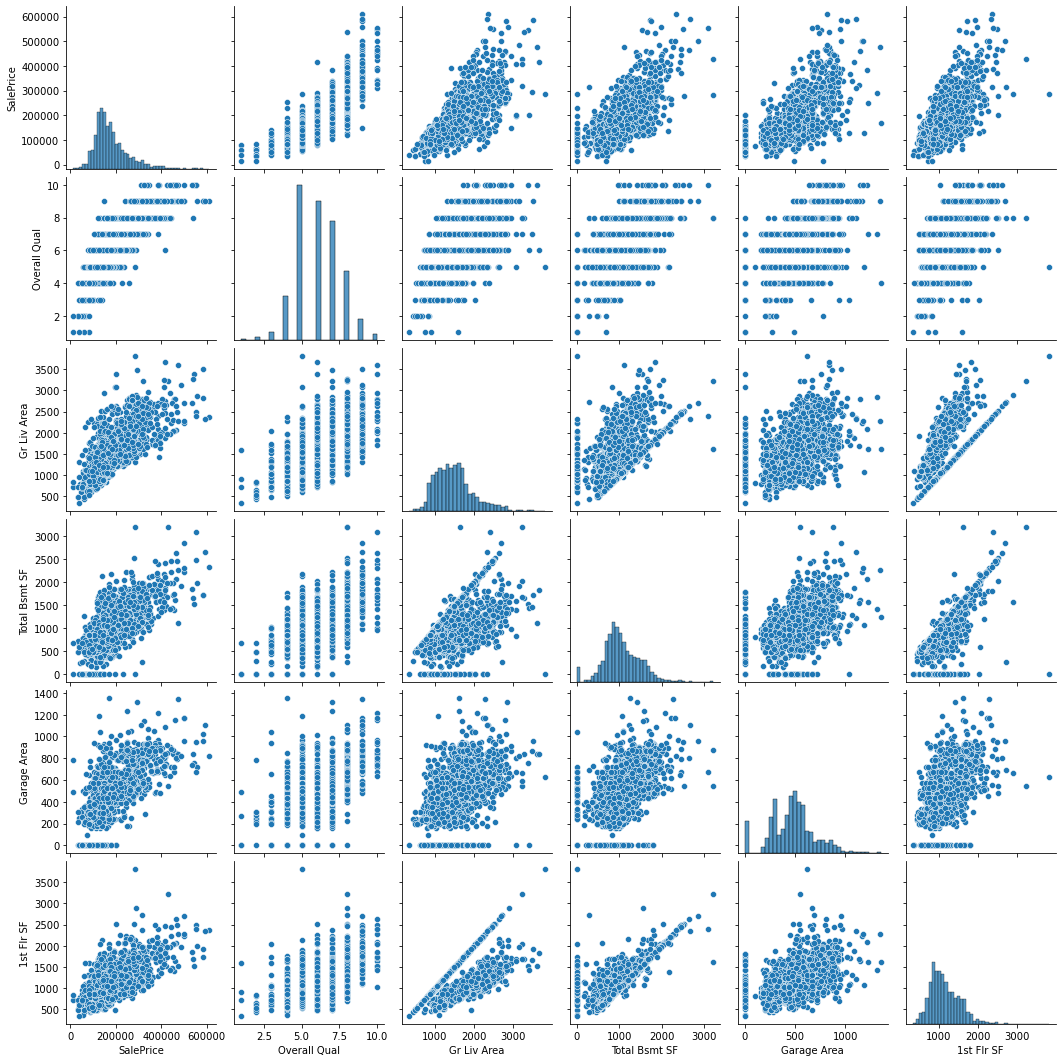

In [35]:
#Pairplot of the top 5
top_5 = list(df_filtered_1.corr()['SalePrice'].sort_values(ascending=False).head(6).index)
sns.pairplot(df_filtered_1[top_5]);

#### Observations
There seems to be a high correlation between 1st Flr SF and the Grade of the living area.
and the distribution of the variables are all right skrewed one way or the other.
Interestingly, 2nd Flr SF is not within the top 5. We can assume for now that the 2 second of a home is of less importance as compared to the frist floor.

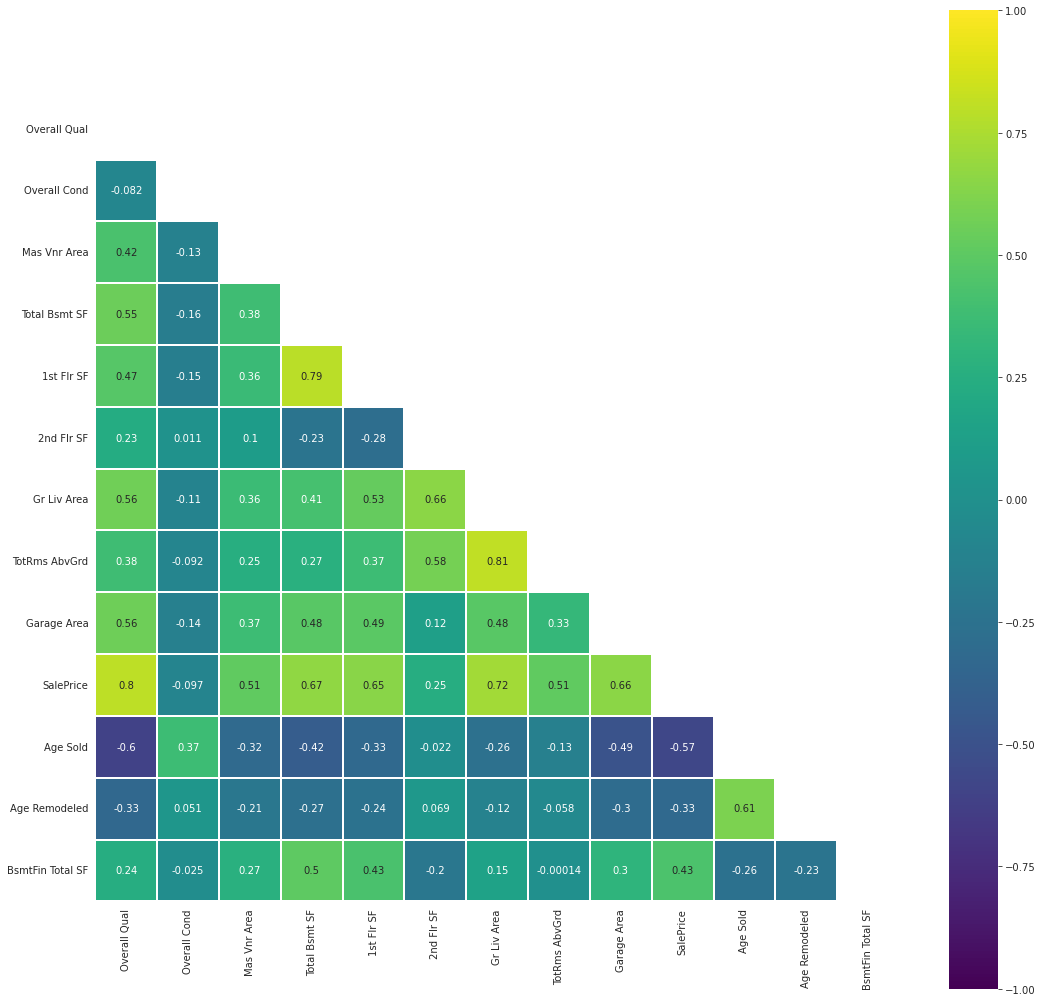

In [36]:
# Plot heatmap
plt.figure(figsize=(18,18))

corr = df_filtered_1.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
    sns.heatmap(corr,mask=mask,square= True,annot=True, linewidths=0.25,vmin = -1, vmax = 1, cmap='viridis')
    
plt.show()

#### Observations

While there are strong correlation when it comes to the different Square Feet and Living Area, this is expected as the measurements required would be similiar.

Interesting to see that there is a slightly negative correlation to Overall Quality vs Overall Condition and also the extremely small correlation of Overall Condition vs Age Sold

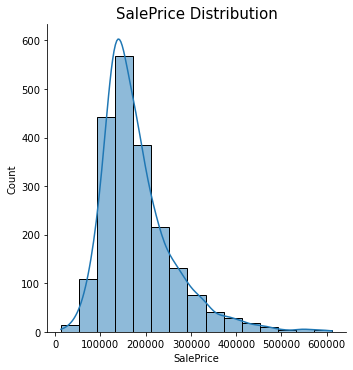

In [37]:
#Histogram of SalesPrice
sns.displot(df_filtered_1['SalePrice'],bins=15,kde=True)
plt.title('SalePrice Distribution',size=15);

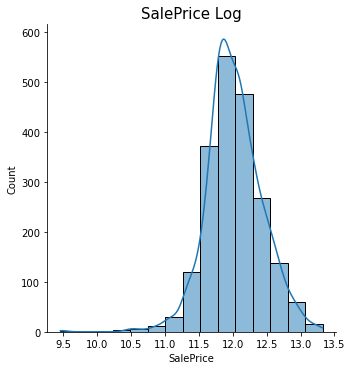

In [38]:
# Would log transforming the Saleprice get a better model?
sns.displot(np.log(df_filtered_1['SalePrice']),bins=15,kde=True)
plt.title('SalePrice Log',size=15);

#### Observations
Looks like our sales price is skrewed to the right, with most of the property price falling between \$100k - \$200k 

Log transforming it, made it skrew exactly in the opposite direction making it pointless to do so.

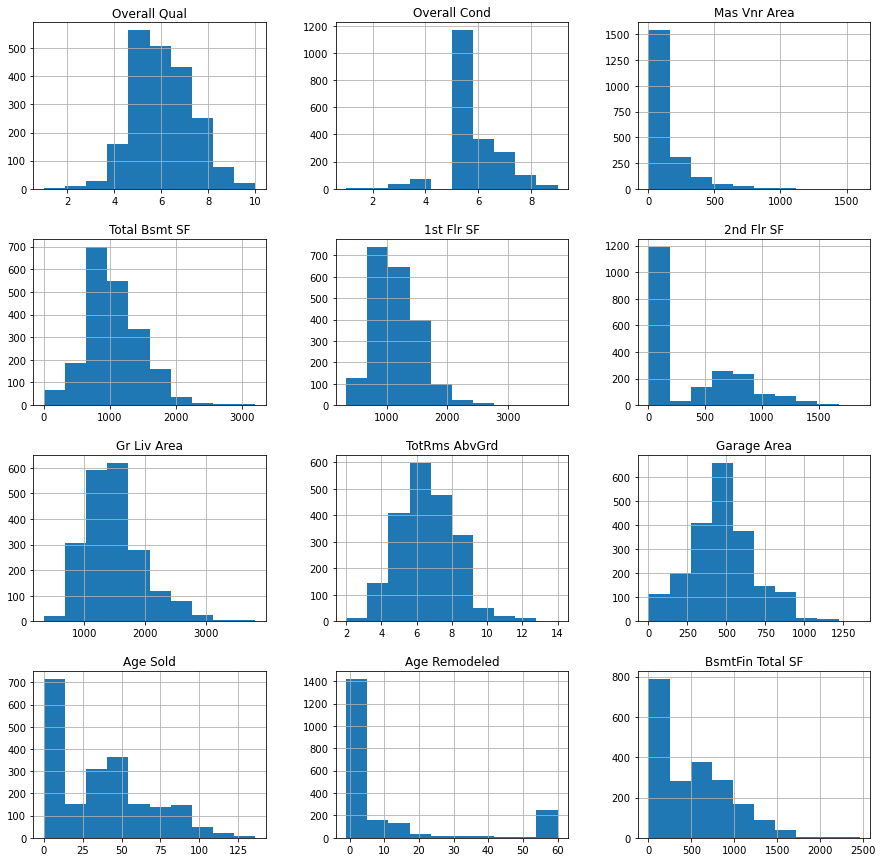

In [39]:
# Histogram of all the other numeric variables
df_filtered_1.drop('SalePrice',axis=1).hist(figsize=(15,15));

#### Observations
From this we can tell that Overall Qual, Total Rooms AbvGrd, 1st Flr SF and Gr Liv Area actually has a very similar distribution to sales price of the property.

Interesting to see that there are homes aged above 100 years old. This is not something we can find in a Singapore context yet.

In [40]:
print('Final Shape of the cleaned Dataset for Machine learning:',df_filtered_1.shape)

Final Shape of the cleaned Dataset for Machine learning: (2049, 46)


## Model_Preprocessing

The steps taken here, are in summary:

1. One hot encode all Norminal Variables using pd.get_dummies
2. Separate out the Ordinal variables to maintian the attributes as is
3. Use polynomial features on the numerical columns to create interaction and reduce bias.
4. Standardize the numerical columns with a mean of 0 and std dev of 1.
5. Finally split the dataset into training and testing set to fit into the models later.

In [41]:
# List of Norminal columns to one hot encode
updated_cat_col.extend(['Full Bath','Bsmt Full Bath','TotRms AbvGrd','Fireplaces','Porch','MS SubClass'])#,'Age Remodeled'


# List of Ordinal variables to exclude from any encoding,interactions or scaling
columns_maintain_as_is = ['Overall Qual','Overall Cond']

#List of ALL catergorical variables
columns_categorical = []
columns_categorical.extend(updated_cat_col)
columns_categorical.extend(columns_maintain_as_is)

# Declare independent and dependent variable
X = df_filtered_1.drop('SalePrice',axis=1)
y = df_filtered_1['SalePrice'] #log dependent variable to for normal distribution

#List of ALL numerical variables
columns_num = list(X.drop(columns_categorical,axis=1).columns)

#Dummify Norminal Variables only
X_dummy = pd.get_dummies(X[updated_cat_col],drop_first=True)

#Polynomial Features excluding ALL catergorical variables
poly = PolynomialFeatures(interaction_only=True,include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X[columns_num]),index=X.index)

#Standardize using StandarScaler
ss = StandardScaler()
ss.fit(X_poly)
X_ss = pd.DataFrame(ss.transform(X_poly),columns = X_poly.columns,index=X_poly.index)

#Join the X dataframe back together
Z = [X_dummy,X_ss,X[columns_maintain_as_is]]
Z = Z[0].join(Z[1:])

#Train Test Split
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)


In [42]:
print('Shape of the train dataset after preprocessing',Z.shape)

Shape of the train dataset after preprocessing (2049, 164)


## Machine_Learning

I'll be training the data using 4 differet types of models to try and predict the sale price of a property:

* Linear Regression - This would be considered my baseline model, using a regression line to try and predict prices
* Ridge - As the data suffer from multicollinearity, I expect the ridge model to work better
* Lasso - Using Lasso which tend to make coefficients to absolute zero I hope to get a model with better feature selection.
* ElasticNet - Finally with Elastic Net, which is a combination of both L1 regularization and L2 regularization I want to see if both shrinking the coefficients as well as eliminating some of the insignificant ones would result in a more accurate model.

In [43]:
#Train all the models

#Linear Regression
lr = LinearRegression()
lr.fit(Z_train,y_train)

#RidgeCV
ridge_cv = RidgeCV(alphas=np.logspace(0, 5, 100),scoring='r2',cv=5)
ridge_cv.fit(Z_train,y_train)

#LassoCV
lasso_cv = LassoCV()
lasso_cv.fit(Z_train,y_train)

#ElasticNetCV lend more weight to Ridge from previous running of model
enet_model = ElasticNetCV(alphas=np.linspace(0.3, 1.0, 100),l1_ratio=0.5,cv=5)
enet_model.fit(Z_train,y_train)

print('Successful')

Successful


In [44]:
#Test the model on the test set
lr_pred = lr.predict(Z_test)
ridge_pred = ridge_cv.predict(Z_test)
lasso_pred = lasso_cv.predict(Z_test)
enet_pred = enet_model.predict(Z_test)

#Test the model on the train set
lr_pred_train = lr.predict(Z_train)
ridge_pred_train = ridge_cv.predict(Z_train)
lasso_pred_train = lasso_cv.predict(Z_train)
enet_pred_train = enet_model.predict(Z_train)


In [45]:
#Create a dataframe of the ML results

models = [lr,ridge_cv,lasso_cv,enet_model]

models_index = ['Linear Reg','Ridge','Lasso','ElasticNet']

models_test_predictions =[lr_pred,ridge_pred,lasso_pred,enet_pred]
models_train_predictions =[lr_pred_train,ridge_pred_train,lasso_pred_train,enet_pred_train]

model_dict= {'Cross_val_score':[],'Best Alpha':[],'Test_RMSE':[],'Train_RMSE':[],'RMSE_Diff':[],
             'Test_R2':[],'Train_R2':[],'R2_Diff':[]}

#Alpha
model_dict['Best Alpha'] = [np.nan,ridge_cv.alpha_,lasso_cv.alpha_,enet_model.alpha_]

#Cross Val Score
for model in models:
    model_dict['Cross_val_score'].append(cross_val_score(model,Z_train,y_train).mean())
    
#RMSE
for pred_test,pred_train in zip(models_test_predictions,models_train_predictions):
    model_dict['Test_RMSE'].append(metrics.mean_squared_error(y_pred=pred_test,y_true=y_test,squared=False))
    model_dict['Train_RMSE'].append(metrics.mean_squared_error(y_pred=pred_train,y_true=y_train,squared=False))
    model_dict['Test_R2'].append(metrics.r2_score(y_test,pred_test))
    model_dict['Train_R2'].append(metrics.r2_score(y_train,pred_train))
    
#Overfit?       
model_dict['RMSE_Diff'] = [model_dict['Test_RMSE'][x]-model_dict['Train_RMSE'][x] for x in range(4)]
model_dict['R2_Diff'] = [model_dict['Test_R2'][x]-model_dict['Train_R2'][x] for x in range(4)]  

df_model = pd.DataFrame(model_dict,index=models_index)
df_model['Overfit?'] = df_model.apply(lambda x:'Yes'if (x['R2_Diff']<0) else 'No',axis=1)

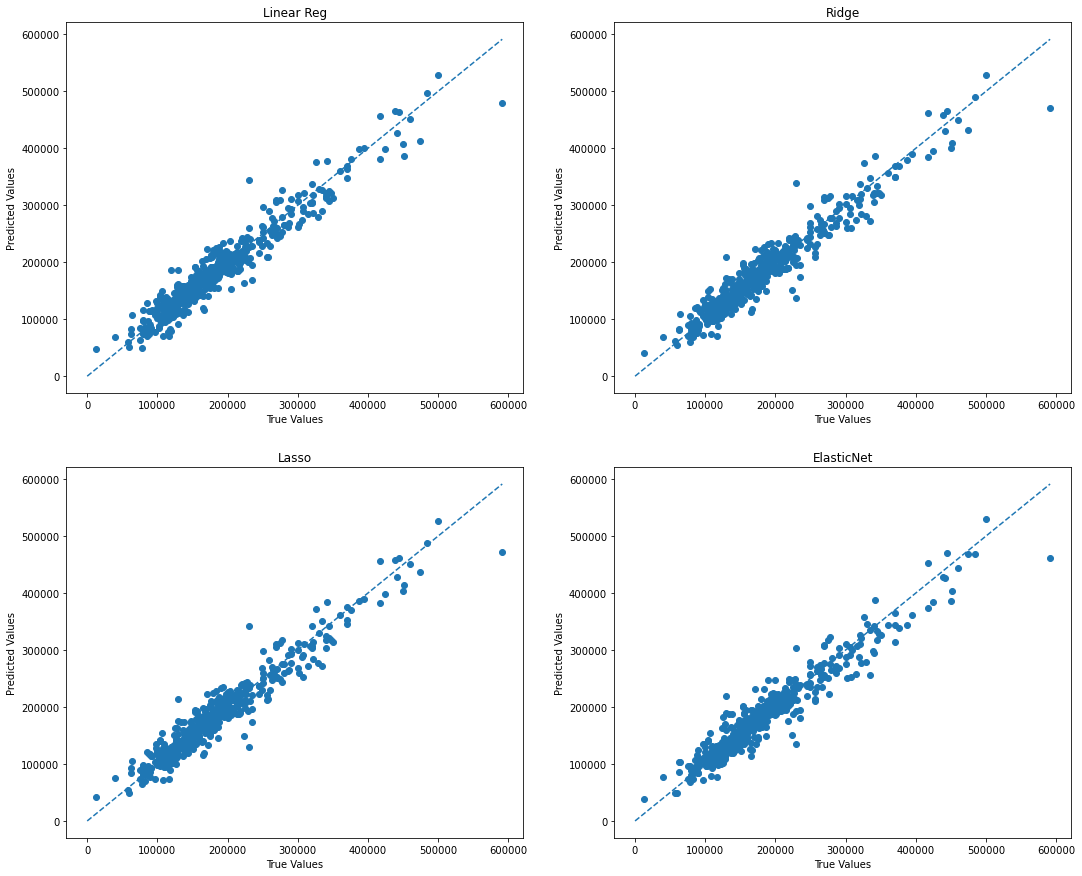

Cross_val_score  Best Alpha     Test_RMSE    Train_RMSE  \
Linear Reg         0.894984         NaN  20745.704034  19445.415090   
Ridge              0.910076   12.915497  20829.946482  20514.079819   
Lasso              0.910507   91.023817  20934.433581  20846.212052   
ElasticNet         0.902151    0.300000  21997.865793  23263.891714   

              RMSE_Diff   Test_R2  Train_R2   R2_Diff Overfit?  
Linear Reg  1300.288945  0.931924  0.939715 -0.007791      Yes  
Ridge        315.866663  0.931370  0.932907 -0.001537      Yes  
Lasso         88.221529  0.930680  0.930717 -0.000037      Yes  
ElasticNet -1266.025920  0.923458  0.913715  0.009744       No

In [46]:
# Plot the relationship between the actual and predicted values.
plt.figure(figsize = (18, 15))
count = 1

for pred,name in zip(models_test_predictions,models_index):
    plt.subplot(2,2,count)
    plt.scatter(y_test, pred)
    plt.plot([0, max(max(y_test),max(pred))],
             [0, max(max(y_test),max(pred))],
             linestyle = '--')
    plt.title(name)
    plt.xlabel('True Values', fontsize = 10)
    plt.ylabel('Predicted Values', fontsize = 10)
    count+=1
    
plt.show()
df_model

#### Observations

Susprisingly all 4 models seems to give very similiar results.

The Linear Regression Model actually had the lowest RMSE but the worse cross_val_score.

Ridge edged out Lasso by a very small margin and the ElasticNet model performed the worse of the four.

Lets take a look at their residual and variance to look at the skew and see if they've met the linear assumption

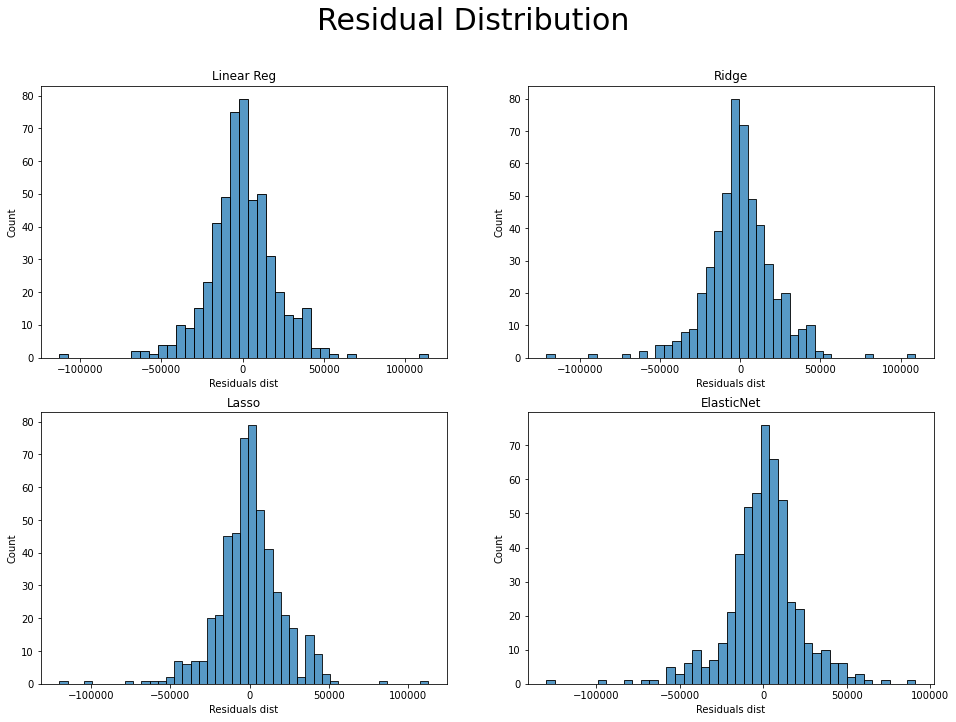

In [47]:
test_preds = [lr_pred, ridge_pred, lasso_pred, enet_pred ]
resi = []

#Residual Distribution

plt.figure(figsize=(16,11))
plt.suptitle('Residual Distribution',fontsize=30)

for (i,p),t in zip(enumerate(test_preds),list(df_model.index)):
    residuals = p - y_test
    plt.subplot(2,2,i+1)
    sns.histplot(residuals)
    plt.title(t)
    plt.xlabel('Residuals dist')
    
    resi.append(residuals)
    
plt.show()

#### Observations
It can be save to say that for all 4 models, the residuals are normally distributed with the exception of 2 outliers in both directions (except for the Linear Reg having only 1 negative outlier).

However, efforts made to improve the predictions by removing the outliers has resulted in an over fit of the models. (see appendix below)

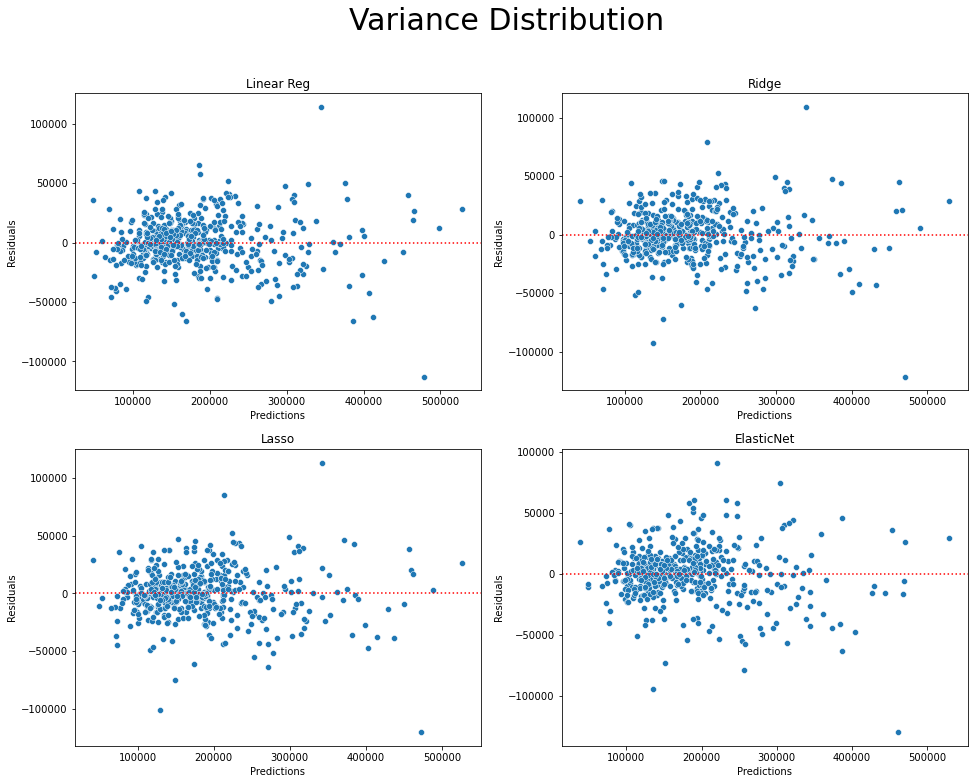

In [48]:
# Variance Distribution

plt.figure(figsize=(16,12))
plt.suptitle('Variance Distribution',fontsize=30)

for (i,p),t,r in zip(enumerate(test_preds),models_index,resi):
    residuals = p - y_test
    plt.subplot(2,2,i+1)
    sns.scatterplot(x=p,y=r)
    plt.axhline(y=0,linestyle = 'dotted',color = 'r')
    plt.title(t)
    plt.xlabel('Predictions')
    plt.ylabel('Residuals')
plt.show()

#### Observations
For all 4 models they're quite symmetrically distributed around the 0 of the y-axis and in general there isn't any clear pattern discernable.

In [49]:
# Get the top 10 and bottom 10 coefficients
df_coef_lr = top_bottom_coef(lr,'Linear Reg')
df_coef_ridge = top_bottom_coef(ridge_cv,'Ridge')
df_coef_lasso = top_bottom_coef(lasso_cv,'Lasso')
df_coef_enet = top_bottom_coef(enet_model,'ElasticNet')

coef_list = [ df_coef_lr,df_coef_ridge,df_coef_lasso,df_coef_enet]

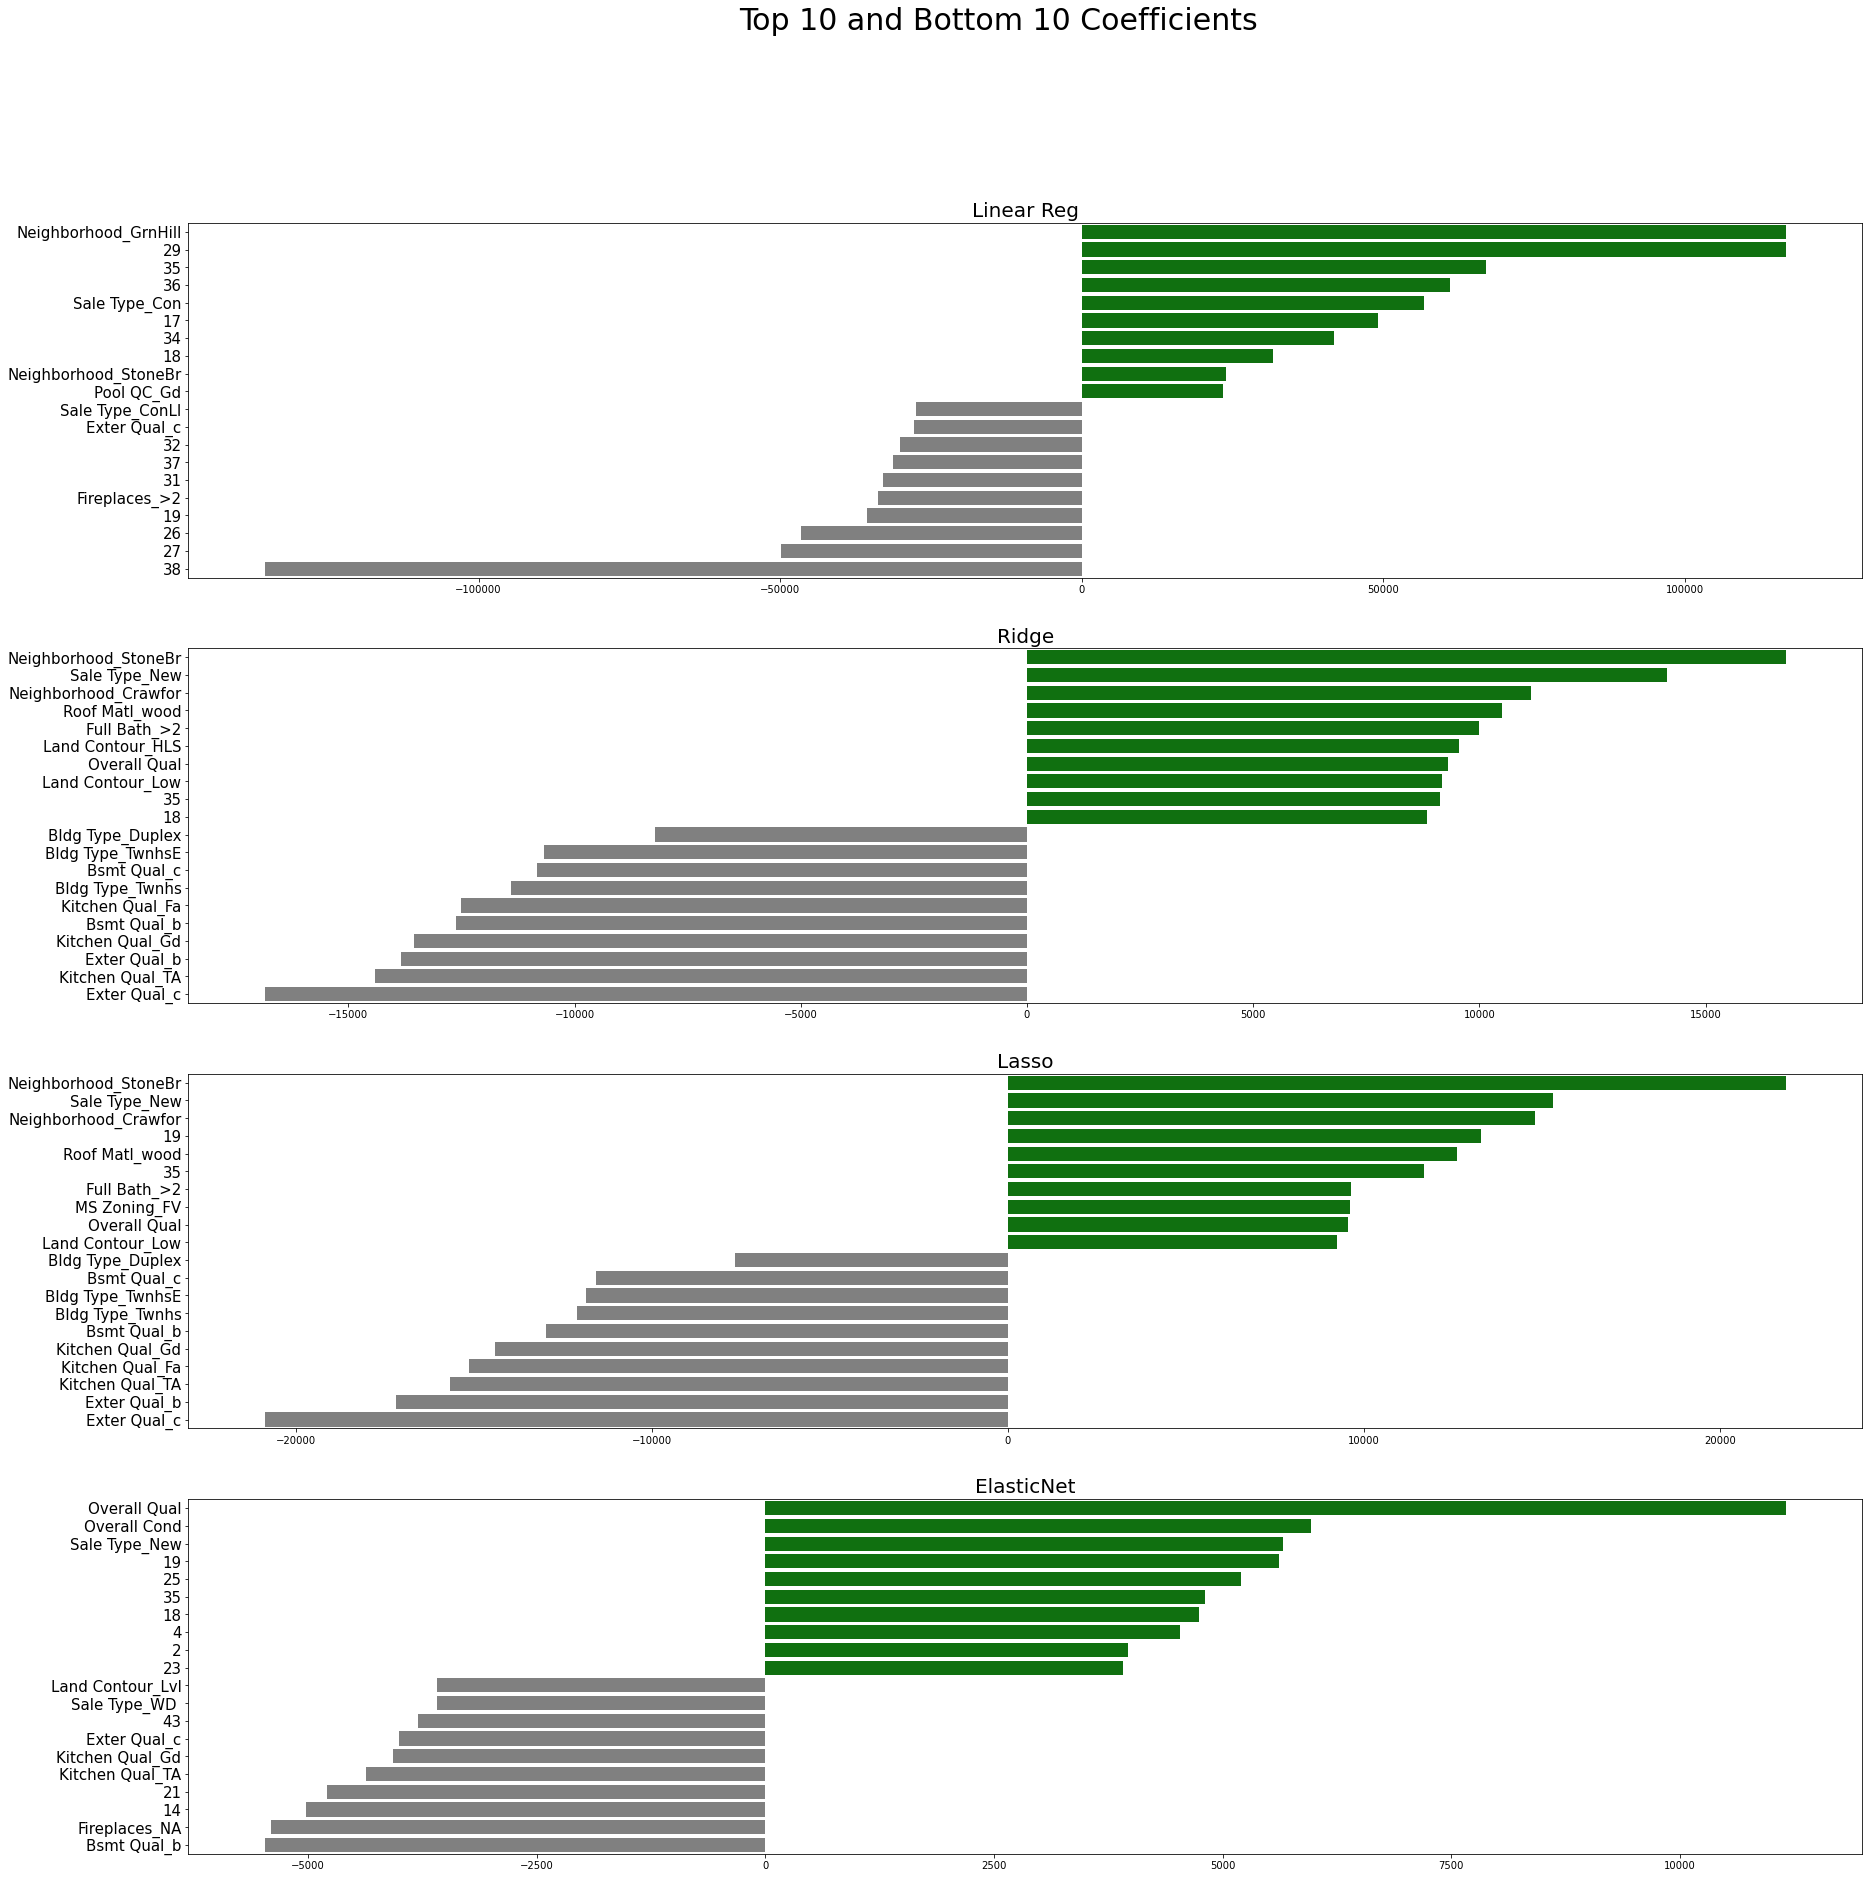

In [50]:
#plot them out
plt.figure(figsize=(30,30))
plt.suptitle('Top 10 and Bottom 10 Coefficients',fontsize=30)

for (i,p),t in zip(enumerate(coef_list),models_index):
    plt.subplot(4,1,i+1)
    sns.barplot(data=p.T,
                orient='h',
                palette=['Green','Green','Green','Green','Green','Green','Green','Green','Green','Green',
                                  'Gray','Gray','Gray','Gray','Gray','Gray','Gray','Gray','Gray','Gray'])
    plt.tick_params(axis='y', labelsize =15)
    plt.title(t,fontsize=20)
    
plt.show()

## Kaggle_Submission

In [51]:
#Clean up the kaggle test dataset to preprocess and get predictions
kaggle = kaggle_submission(df_test)

#Dummify Norminal Variables only
test_dummy = pd.get_dummies(kaggle[updated_cat_col],drop_first=True)

# To solve the mismatch of unique attributes between the test and train dataset
missing_cols = set(X_dummy.columns)-set(test_dummy.columns)
#Add a missing column in test set with default value equal to 0
for c in missing_cols:
    test_dummy[c] = 0
#Remove additional columns not in train set
test_dummy=test_dummy[X_dummy.columns]

#Polynomial Features excluding ALL catergorical variables
poly_test = PolynomialFeatures(interaction_only=True,include_bias=False)
test_poly = pd.DataFrame(poly_test.fit_transform(kaggle[columns_num]),index=kaggle.index)

#Standardize using StandarScaler
test_ss = pd.DataFrame(ss.transform(test_poly),columns=test_poly.columns,index=test_poly.index)

#Join the X dataframe back together
Z_test_kaggle = [test_dummy,test_ss,kaggle[columns_maintain_as_is]]
Z_test_kaggle = Z_test_kaggle[0].join(Z_test_kaggle[1:])

In [52]:
#Run predictions on the processed kaggle test dataset
#Linear Regression
lr_ks = lr.predict(Z_test_kaggle)

#RidgeCV
ridge_ks = ridge_cv.predict(Z_test_kaggle)

#LassoCV
lasso_ks = lasso_cv.predict(Z_test_kaggle)

#ElasticNetCV
enet_ks = enet_model.predict(Z_test_kaggle)
    
df_kaggle_pred = pd.DataFrame({'linear':lr_ks,'ridge':ridge_ks,'lasso':lasso_ks,'enet':enet_ks},index=Z_test_kaggle.index)

In [53]:
#Push each prediction of the test dataset into a dataframe for upload to kaggle

for model,result in df_kaggle_pred.iteritems():
    x = pd.DataFrame({'Id': df_kaggle_pred.index,'SalePrice':result})
    x.to_csv('./assets/datasets/predictions/'+model+'kaggle_submission.csv',index=False,)

In [54]:
#Kaggle Results
pd.DataFrame({'linear_RMSE':[22392.62358,21944.52317],'ridge_RMSE':[21383.60006,21944.52317],'lasso_RMSE':[21362.61136,20019.08705],'enet_RMSE':[22484.49178,20531.43927]},index=['Kaggle Public RMSE','Kaggle Private RMSE']).T

Kaggle Public RMSE  Kaggle Private RMSE
linear_RMSE         22392.62358          21944.52317
ridge_RMSE          21383.60006          21944.52317
lasso_RMSE          21362.61136          20019.08705
enet_RMSE           22484.49178          20531.43927

#### Oberservations
Not suprisingly, they've all returned very similiar RMSE for the kaggle submission. Interestingly, although ridge did slightly better on the Z_test, however for kaggle it is the lasso model that returned the slightly lower RMSE.

Perhaps taking the mean of all 4 predictions would give a better result.

## Conclusion

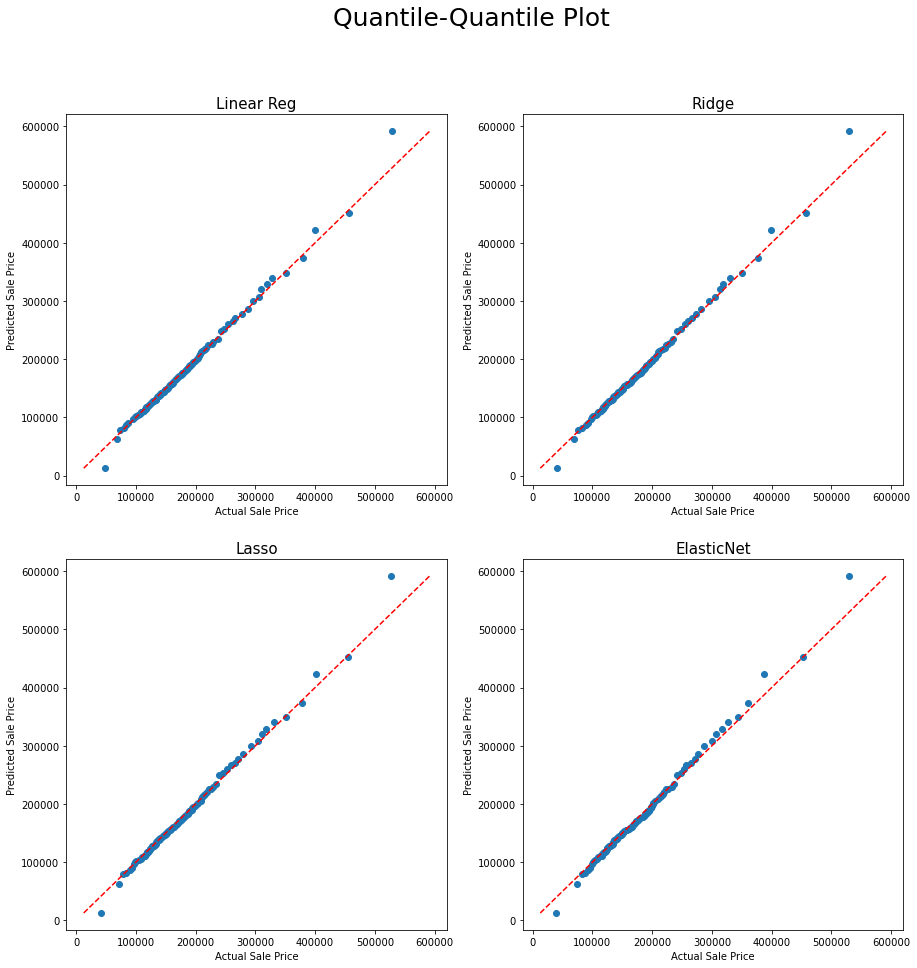

In [55]:
# QQ plot
plt.figure(figsize=(15,15))
plt.suptitle('Quantile-Quantile Plot',fontsize=25)

for (i,p),t in zip(enumerate(models_test_predictions),models_index):
    plt.subplot(2,2,i+1)
    qq_plot(p)
    plt.title(t,fontsize=15)
    
plt.show()

Plotting the qq-plot (Quantile-Quantile Plot) we can see that all 4 models behaved very similiarly with the major difference being how far out the outliers were from the actual sales price of the property. It can be say to say that all 4 models would be able to predict with high accuracy the price of the property in Ames if the price range is between 100k to 400k

In [56]:
# t-test
for m,name in zip(models_test_predictions,models_index):
    print(name,stats.ttest_ind(m,y_test),'\n')

Linear Reg Ttest_indResult(statistic=-0.026647665967204616, pvalue=0.9787459468648116) 

Ridge Ttest_indResult(statistic=0.02847074928130777, pvalue=0.977292244817378) 

Lasso Ttest_indResult(statistic=0.014595142874832778, pvalue=0.9883580172967218) 

ElasticNet Ttest_indResult(statistic=0.054889273540766524, pvalue=0.9562373844433699) 



With the P value between 0.95 and 0.98 we can accept the null hypothesis that there is no difference in the predictions versus the actual prices except for chance.

Overall using any of the 4 models, a real estate agent would be able to price the houses in Ames with very high accuracy if it is between a 100k-400k. Any lower or higher and the model might be extremely inaccurate.

## Recommendations

For improving on the ML models:
1. Find a better way to deal with Outliers. I have not found a good way to deal with outliers. Any outliers dropped (other then the 2 at the start) resulted in the models leaning towards a greater overfit.
2. Drop or feature engineer more variables expecially those that have very high multicollinearity
3. Have a better way to combine certain categories to lessen the amount of 'noise'
4. Other factors could perhaps be taken into account also like the crime rate and socio-economic status of the neighborhood
5. Further Data exploration and cleaning could have been done but was ignored due to time constraint, like for example having full bathroom listed as multi but basement area as 0.
6. One of the issues could be that, there are not enough low transacted properties and extremely expensive properties data to feed into the model. Perhaps if more data was available for properties priced at the extreme ends, the model would be able to return better results overall.

For client or real estate agent looking to use the model to estimate sale price:
1. Less is more, too many measurements of same information would cause the predictions to go way off for unseen data. example having the count of the number cars able to fit into the garage and the total garage space is not only redundant but also hurts the accurarcy of the models. (Although that information could be used for marketing purposes)
2. Certain data could could be combined together. Example the type of porch rather then tracked separately.
3. The ability to record the 'right' attributes into the model is key to a better price estimate.

## Appendix

### A hit and miss on working with Outliers

Would removing outliers 3std away from the mean help predictions? 

And what about if I just remove a few from looking at the scatterplot?

Lets take a look

#### Removing outliers 3 std from the mean

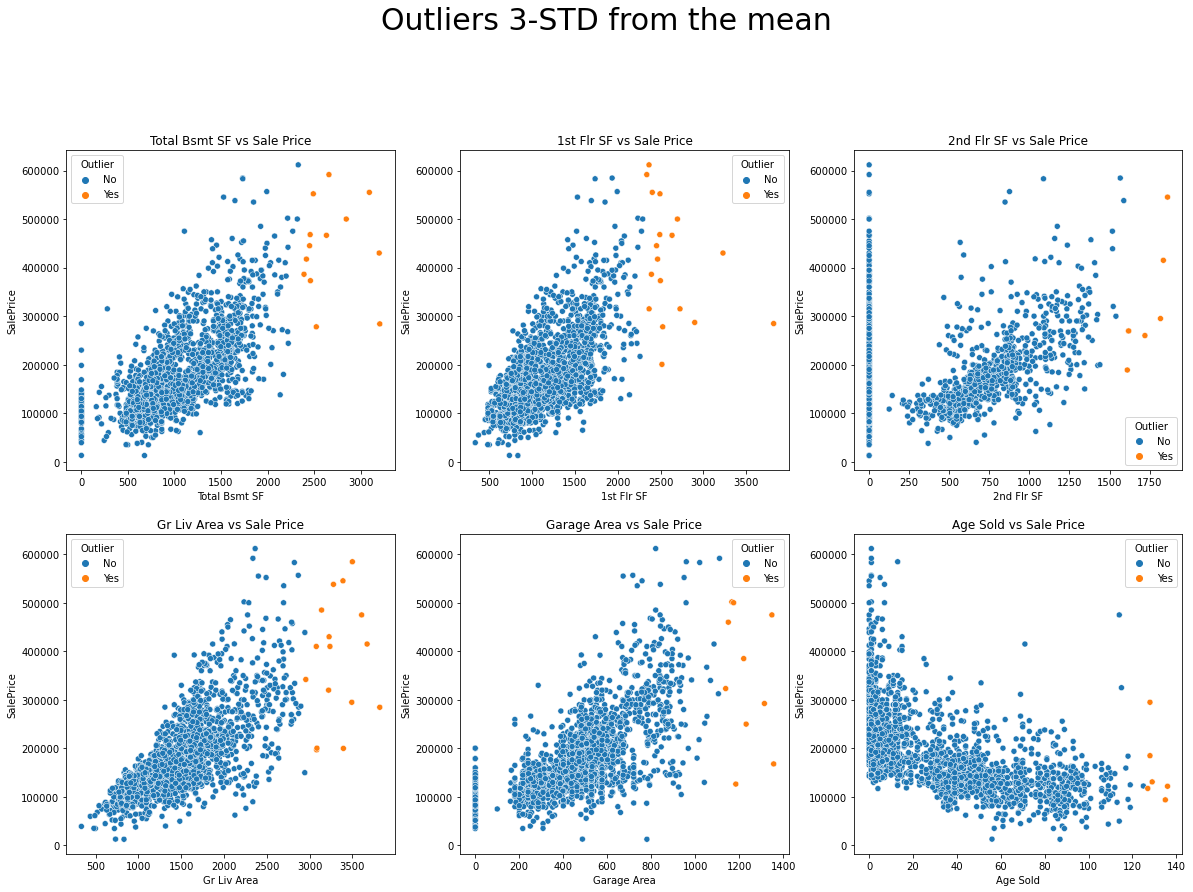

In [57]:
temp = df_filtered_1[['Total Bsmt SF','1st Flr SF','2nd Flr SF','Gr Liv Area','Garage Area','Age Sold','SalePrice']]
outliers = ['outlier_tbsf','outlier_1st','outlier_2nd','outlier_GLA','outlier_GA','outlier_AS']


for a,b in zip(list(temp.columns),outliers):
    m = np.mean(temp[a])
    st = np.std(temp[a])
    temp[b] = np.where((temp[a]>(m-3*st)) & (temp[a]<(m+3*st)),'No', 'Yes')

plt.figure(figsize=(20,20))
plt.suptitle('Outliers 3-STD from the mean', fontsize=30)
for (i,col),o in zip(enumerate(temp),outliers):
    plt.subplot(3,3,i+1)
    sns.scatterplot(data=temp,x=col,y='SalePrice',hue=o)
    plt.legend(title='Outlier')
    plt.title(col+' vs Sale Price')
plt.show()

#### Observations
I decided to try and remove any attributes highlighted that are 3 std dev from the mean assuming the distribution is Gaussian or Gaussian-like. 

This was done using the below marked out code.

In [58]:
#Remove outliers 3 dev from mean

#def remove_3std__outliers(df,col):
#    m = np.mean(df[col])
#    st = np.std(df[col])
#    df = df[(df[col]>(m-3*st)) & (df[col]<(m+3*st))]
#    return df

#for col in df_filtered_1[['Garage Area','Gr Liv Area','1st Flr SF','Total Bsmt SF']]:
#    df_filtered_1 = remove_3std__outliers(df_filtered_1,col)

I then trained the models with this filtered data and actually got a slightly worse off RMSE then if I did not filter out the 'outliers'

In [59]:
#Results
pd.read_csv('./assets/datasets/predictions/z_outlier_fail_train_test_results.csv').set_index(['Unnamed: 0'])

Test_RMSE    Train_RMSE    RMSE_Diff   Test_R2  Train_R2  \
Unnamed: 0                                                                
Linear Reg  21216.493303  17850.730582  3365.762721  0.912333  0.937723   
Ridge       21185.473688  18412.342157  2773.131531  0.912589  0.933742   
Lasso       21934.779186  19137.166117  2797.613069  0.906296  0.928423   
ElasticNet  23484.692008  21589.357080  1895.334927  0.892586  0.908904   

             R2_Diff Overfit?  
Unnamed: 0                     
Linear Reg -0.025390      Yes  
Ridge      -0.021153      Yes  
Lasso      -0.022126      Yes  
ElasticNet -0.016318      Yes

#### Removing numeric outliers from eyeballing the scatter plot

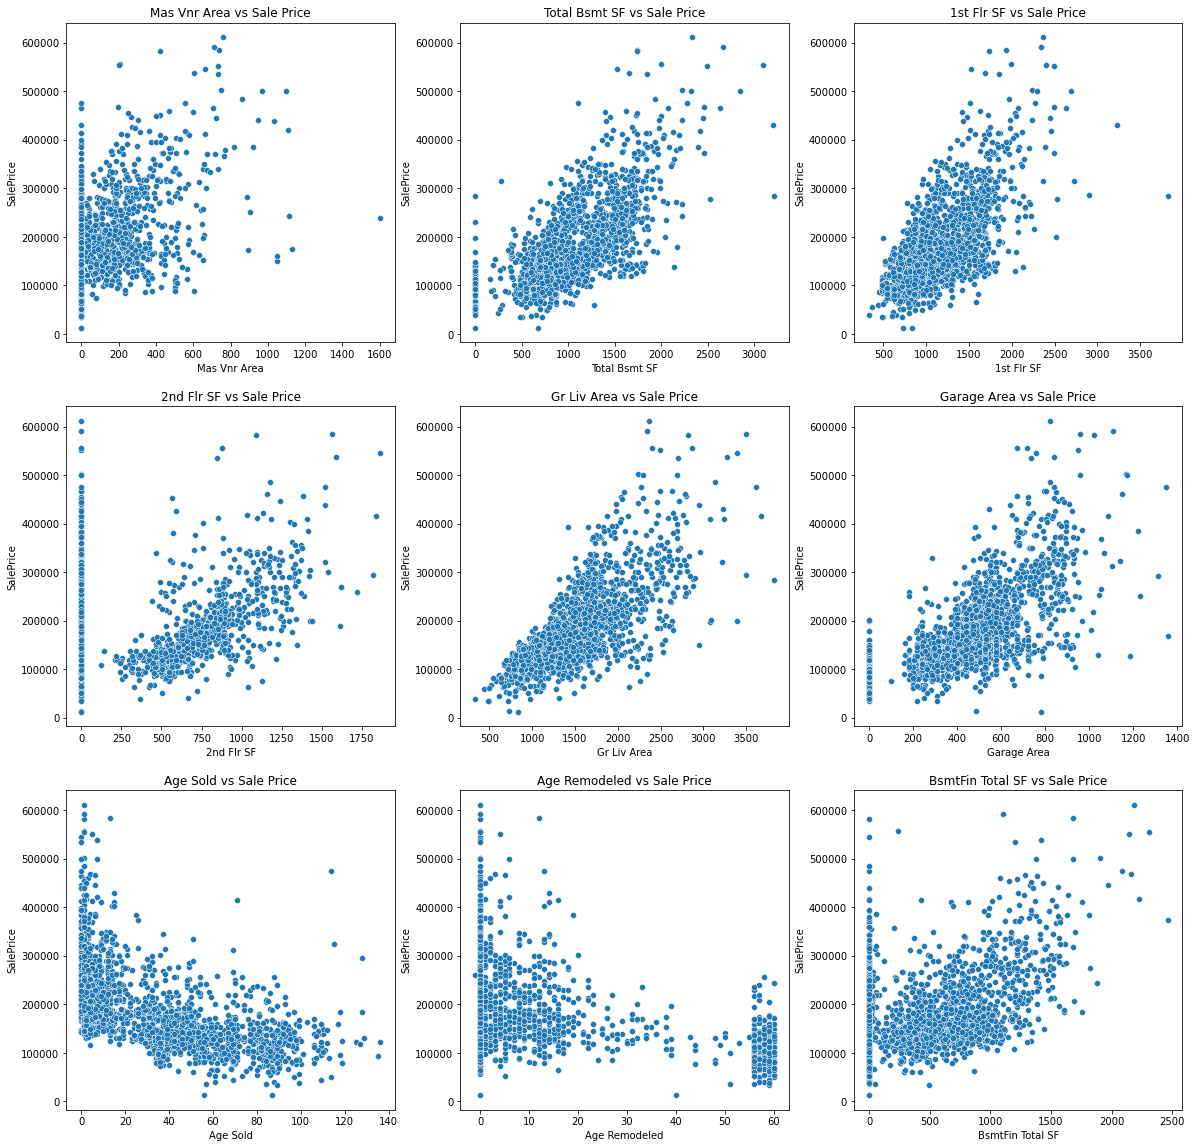

In [60]:
#Look at the cleaned up numeric data
columns = list(df_filtered_1.dtypes.index[(df_filtered_1.dtypes=='int64') | (df_filtered_1.dtypes=='float64')])
#Redefine numeric data columns
_ = ['SalePrice','Overall Qual','Overall Cond','TotRms AbvGrd']
columns_updated = [e for e in columns if e not in _]

#plot
plt.figure(figsize=(20,20))
for i,column in enumerate(columns_updated):
        plt.subplot(3,3,i+1)
        create_scatterplot(df_filtered_1,column)    
plt.show()

#### Observations
Just from looking at the scatter plot we can identify very obvious looking outliers in relation to sales price
1. Mas Vnr Area greater then 1400
2. Total Bsmt SF greater then 3000
3. 1st Flr SF more then 3000
4. Age sold above 60 at greater then 350k

I then proceeded to drop them using the below code:

In [61]:
# Dropping the observable outliers

#df_filtered_1 = df_filtered_1[df_filtered_1['Mas Vnr Area']<1400]
#df_filtered_1 = df_filtered_1[df_filtered_1['Total Bsmt SF']<3100]
#df_filtered_1 = df_filtered_1[(df_filtered_1['Age Sold']<60) | (df_filtered_1['SalePrice']<350000)]
#df_filtered_1 = df_filtered_1[df_filtered_1['1st Flr SF']<3500]

This resulted in a more overfitted model and so while the train RMSE improved, the ability to predict the sale price of unknown data did not fare better.

In [62]:
pd.read_csv('./assets/datasets/predictions/z_outlier_fail2_train_test_results.csv').set_index(['Unnamed: 0'])

Test_RMSE    Train_RMSE    RMSE_Diff   Test_R2  Train_R2  \
Unnamed: 0                                                                
Linear Reg  22255.373211  18693.231615  3562.141596  0.923644  0.942484   
Ridge       20809.985292  19550.874295  1259.110998  0.933240  0.937085   
Lasso       21245.484687  20270.501447   974.983240  0.930417  0.932368   
ElasticNet  23005.047306  23471.652303  -466.604997  0.918413  0.909320   

             R2_Diff Overfit?  
Unnamed: 0                     
Linear Reg -0.018839      Yes  
Ridge      -0.003845      Yes  
Lasso      -0.001951      Yes  
ElasticNet  0.009093       No

### Fine tuning by dropping cofficients made 0 by Lasso - Does it help in this scenario?

Finally I tried loop the lassso model 100 times, dropping the cofficients made 0 by Lasso_CV to see it I can get a better fitted model and a better RMSE.

This actually gave the linear, ridge, and elastic net models a better RMSE but did not really affect the original Lasso model which still gave the best result overall. As such I decided to take it out of the equation.

The kaggle results and code can be seen below:

In [63]:
pd.DataFrame({'linear1_RMSE':[21818.95315,20652.59816],'ridge1_RMSE':[21479.46825,20279.15599],'lasso1_RMSE':[21365.69176,20019.70068],'enet1_RMSE':[22575.68813,20767.23644]},
             index=['Kaggle Public RMSE','Kaggle Private RMSE']).T

Kaggle Public RMSE  Kaggle Private RMSE
linear1_RMSE         21818.95315          20652.59816
ridge1_RMSE          21479.46825          20279.15599
lasso1_RMSE          21365.69176          20019.70068
enet1_RMSE           22575.68813          20767.23644

In [64]:
# "Original" Kaggle submission for comparison
#          Kaggle Public RMSE 	Kaggle Private RMSE
#linear_RMSE	22392.62358 	21944.52317
#ridge_RMSE 	21383.60006 	21944.52317
#lasso_RMSE 	21362.61136 	20019.08705
#enet_RMSE  	22484.49178 	20531.43927



# Loop Lasso 100 times and drop columns as it iterates
'''
count = 0 
while count < 100:
    if count == 0:
        a = pd.DataFrame(lasso_cv.coef_,index = list(Z.columns))
        b = list(a[a[0]==0].index)
        Z.drop(columns=b,axis = 1,inplace=True)
        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)
        l1 = LassoCV()
        l1.fit(Z_train,y_train)
        count+=1
    else:
        a = pd.DataFrame(l1.coef_,index = list(Z.columns))
        b = list(a[a[0]==0].index)
        Z.drop(columns=b,axis = 1,inplace=True)
        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)
        l1 = LassoCV()
        l1.fit(Z_train,y_train)
        count+=100
'''
#Retrain all the models

#Linear Regression
#lr1 = LinearRegression()
#lr1.fit(Z_train,y_train)

#RidgeCV
#ridge_cv1 = RidgeCV(alphas=np.logspace(0, 5, 100),scoring='r2',cv=5)
#ridge_cv1.fit(Z_train,y_train)

#LassoCV
#l1 = LassoCV()
#l1.fit(Z_train,y_train)

#ElasticNetCV lend more weight to Ridge from previous running of model
#enet_model1 = ElasticNetCV(alphas=np.linspace(0.3, 1.0, 100),l1_ratio=0.5,cv=5)
#enet_model1.fit(Z_train,y_train)

### Kaggle Submission ###

# To solve the mismatch of unique attributes between the test and train dataset
#missing_cols = set(Z_test.columns)-set(Z_test_kaggle.columns)
#Add a missing column in test set with default value equal to 0
#for c in missing_cols:
#    Z_test_kaggle[c] = 0
#Remove additional columns not in train set
#Z_test_kaggle=Z_test_kaggle[Z_test.columns]

#Run predictions on the processed kaggle test dataset
#Linear Regression
#lr_ks1 = lr1.predict(Z_test_kaggle)

#RidgeCV
#ridge_ks1 = ridge_cv1.predict(Z_test_kaggle)

#LassoCV
#lasso_ks1 = l1.predict(Z_test_kaggle)

#ElasticNetCV
#enet_ks1 = enet_model1.predict(Z_test_kaggle)
    
#df_kaggle_pred_trial = pd.DataFrame({'linear':lr_ks1,'ridge':ridge_ks1,'lasso':lasso_ks1,'enet':enet_ks1},index=Z_test_kaggle.index)

#Push each prediction of the test dataset into a dataframe for upload to kaggle

#for model,result in df_kaggle_pred_trial.iteritems():
#    x = pd.DataFrame({'Id': df_kaggle_pred.index,'SalePrice':result})
#    x.to_csv('./assets/datasets/predictions/'+model+'kaggle_submission_0000.csv',index=False,)


'\ncount = 0 \nwhile count < 100:\n    if count == 0:\n        a = pd.DataFrame(lasso_cv.coef_,index = list(Z.columns))\n        b = list(a[a[0]==0].index)\n        Z.drop(columns=b,axis = 1,inplace=True)\n        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)\n        l1 = LassoCV()\n        l1.fit(Z_train,y_train)\n        count+=1\n    else:\n        a = pd.DataFrame(l1.coef_,index = list(Z.columns))\n        b = list(a[a[0]==0].index)\n        Z.drop(columns=b,axis = 1,inplace=True)\n        Z_train, Z_test, y_train, y_test = train_test_split(Z, y, random_state=42)\n        l1 = LassoCV()\n        l1.fit(Z_train,y_train)\n        count+=100\n'